In [27]:
%matplotlib inline

In [28]:
import os

In [29]:
%run notebook_setup

# Load data in from Google Drive

from google.colab import drive
drive.mount('/content/drive')

# Transit fitting

*exoplanet* includes methods for computing the light curves transiting planets.
In its simplest form this can be used to evaluate a light curve like you would do with [batman](https://astro.uchicago.edu/~kreidberg/batman/), for example:

In [30]:
import os
HOME = os.environ['HOME']
os.chdir(f'{HOME}/Research/Planets/WASP43/github_analysis/notebooks')

In [107]:
import exoplanet as xo
import joblib
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
import pandas as pd
import pymc3 as pm

from exomast_api import exoMAST_API
from statsmodels.robust.scale import mad
from time import time
from tqdm import tqdm_notebook as tqdm

from arctor import create_raw_lc_stddev, Arctor, run_multiple_pymc3#, setup_and_plot_GTC
from arctor.utils import setup_and_plot_GTC

In [32]:
def debug_message(message, end='\n'):
    print(f'[DEBUG] {message}', end=end)


def warning_message(message, end='\n'):
    print(f'[WARNING] {message}', end=end)


def info_message(message, end='\n'):
    print(f'[INFO] {message}', end=end)

In [33]:
plot_verbose = False
save_now = False
planet_name = 'WASP43'
file_type = 'flt.fits'

HOME = os.environ['HOME']
base_dir = os.path.join(HOME, 'Research', 'Planets', 'WASP43')
data_dir = os.path.join(base_dir, 'data', 'UVIS', 'MAST_2019-07-03T0738')
data_dir = os.path.join(data_dir, 'HST', 'FLTs')
working_dir = os.path.join(base_dir, 'github_analysis', 'savefiles')

In [34]:
planet = Arctor(planet_name, data_dir, working_dir, file_type)
joblib_filename = 'WASP43_savedict_206ppm_100x100_finescale.joblib.save'
joblib_filename = f'{working_dir}/{joblib_filename}'
planet.load_dict(joblib_filename)

[INFO] Initializing Instance of the `Arctor` Object


In [35]:
planet.photometry_df.columns

Index(['aperture_sum_11x41', 'aperture_sum_12x41', 'aperture_sum_13x41',
       'aperture_sum_14x41', 'aperture_sum_15x41', 'aperture_sum_16x41',
       'aperture_sum_17x41', 'aperture_sum_18x41', 'aperture_sum_19x41',
       'aperture_sum_20x41',
       ...
       'aperture_sum_23x60', 'aperture_sum_24x60', 'aperture_sum_25x60',
       'aperture_sum_26x60', 'aperture_sum_27x60', 'aperture_sum_28x60',
       'aperture_sum_29x60', 'aperture_sum_30x60', 'xcenter', 'ycenter'],
      dtype='object', length=402)

In [36]:
if not hasattr(planet, 'photometry_df'):
    # planet.load_dict(joblib_filename)
    planet.clean_cosmic_rays()
    planet.calibration_trace_location()
    planet.identify_trace_direction()
    planet.simple_phots()
    planet.center_all_traces()
    planet.fit_trace_slopes()
    planet.compute_sky_background(subpixels=32)
    planet.compute_columnwise_sky_background()

# Run Multi-Phot

In [37]:
if not hasattr(planet, 'photometry_df'):
    # Set up the list of aperture widths and heights to search
    min_aper_width = 1
    max_aper_width = 100
    min_aper_height = 1
    max_aper_height = 100

    aper_widths = np.arange(min_aper_width, max_aper_width + 2, 5)
    aper_heights = np.arange(min_aper_height, max_aper_height + 2, 5)
    
    planet.do_multi_phot(aper_widths, aper_heights)

# Determine the 'best' photometry SNR

In [38]:
med_photometry_df = np.median(planet.photometry_df, axis=0)
planet.normed_photometry_df = planet.photometry_df / med_photometry_df
planet.normed_uncertainty_df = np.sqrt(planet.photometry_df) / med_photometry_df

In [39]:
planet_fine_photometry_df = planet.photometry_df.copy()

In [40]:
fine_snr_lightcurves = create_raw_lc_stddev(planet)
fine_min_snr = fine_snr_lightcurves[fine_snr_lightcurves.argmin()]
fine_min_snr_colname = planet.photometry_df.columns[fine_snr_lightcurves.argmin()]
fine_min_snr_flux = planet.normed_photometry_df[fine_min_snr_colname]
fine_min_snr_uncs = planet.normed_uncertainty_df[fine_min_snr_colname]
fine_temp = fine_min_snr_colname.split('_')[-1].split('x')
fine_min_snr_aper_width, fine_min_snr_aper_height = np.int32(fine_temp)

In [41]:
info_message(f'Fine Aperture Photometry Resulted in {fine_min_snr:0.0f}ppm with '
             f'{fine_min_snr_aper_width}x{fine_min_snr_aper_height} aperture size; '
             f'with median uncertainties of {np.median(fine_min_snr_uncs)*1e6:0.0f} ppm')

[INFO] Fine Aperture Photometry Resulted in 209ppm with 20x50 aperture size; with median uncertainties of 126 ppm


# Configure system for PyMC3

In [42]:
idx_fwd = planet.idx_fwd
idx_rev = planet.idx_rev

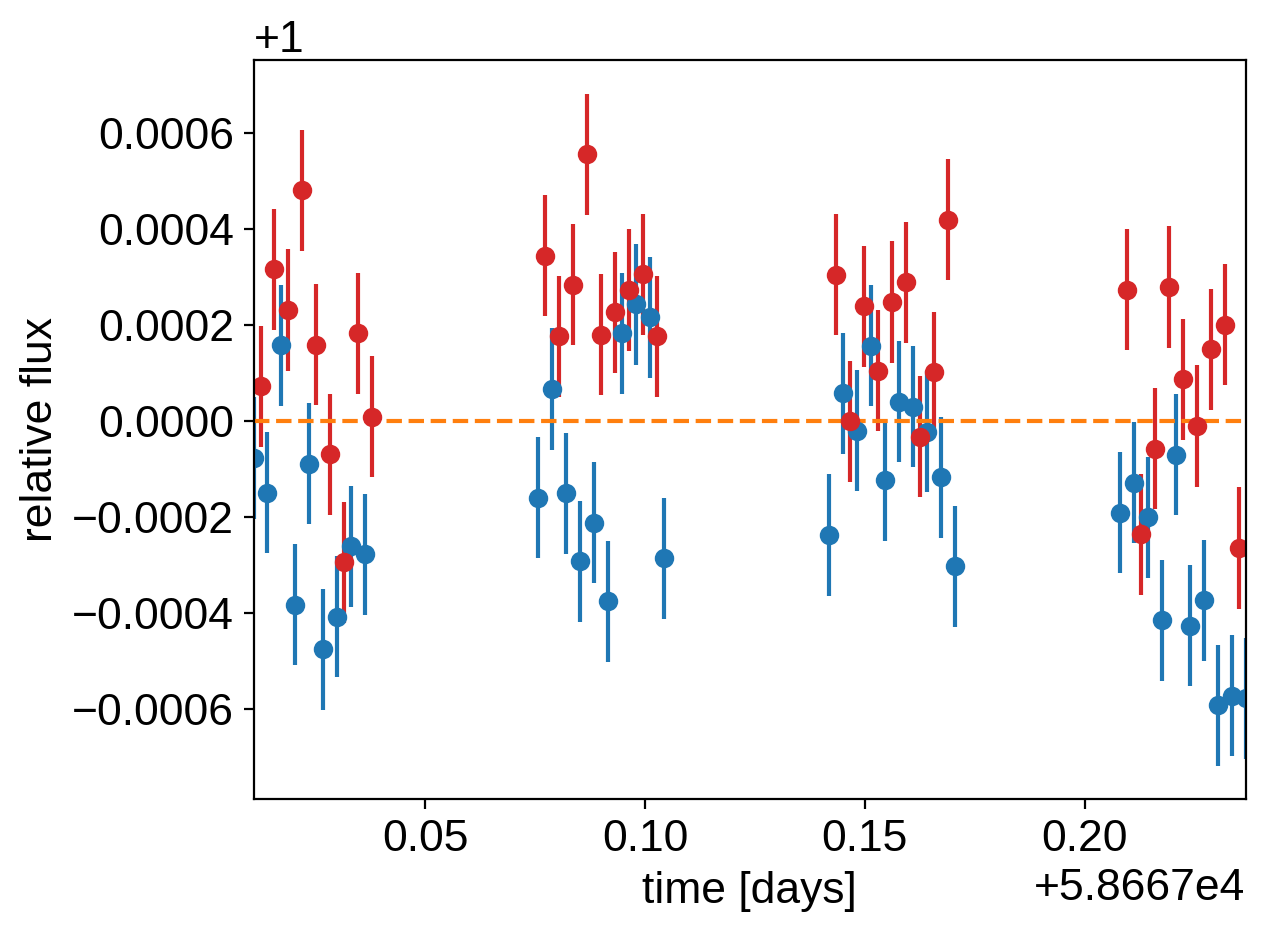

In [43]:
# Compute a limb-darkened light curve using starry
times = planet.times
u = []
flux = planet.normed_photometry_df[fine_min_snr_colname]
yerr = planet.normed_uncertainty_df[fine_min_snr_colname]

plt.errorbar(times[idx_fwd], flux[idx_fwd], yerr[idx_fwd], fmt='o', color="C0")
plt.errorbar(times[idx_rev], flux[idx_rev], yerr[idx_rev], fmt='o', color="C3")
plt.axhline(1.0, ls='--', color='C1')
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.xlim(times.min(), times.max());

But the real power comes from the fact that this is defined as a [Theano operation](http://deeplearning.net/software/theano/extending/extending_theano.html) so it can be combined with PyMC3 to do transit inference using Hamiltonian Monte Carlo.

## The transit model in PyMC3

In this section, we will construct a simple transit fit model using *PyMC3* and then we will fit a two planet model to simulated data.
To start, let's randomly sample some periods and phases and then define the time sampling:

In [44]:
np.random.seed(42)

# time_med = np.median(times)
med_t_diff = np.median(np.diff(times))

Then, define the parameters.
In this simple model, we'll just fit for the limb darkening parameters of the star, and the period, phase, impact parameter, and radius ratio of the planets (note: this is already 10 parameters and running MCMC to convergence using [emcee](https://emcee.readthedocs.io) would probably take at least an hour).
For the limb darkening, we'll use a quadratic law as parameterized by [Kipping (2013)](https://arxiv.org/abs/1308.0009).
This reparameterizations is implemented in *exoplanet* as custom *PyMC3* distribution :class:`exoplanet.distributions.QuadLimbDark`.

In [45]:
print(f'This instance has {mp.cpu_count()} CPUs')

This instance has 16 CPUs


In [46]:
wasp43 = exoMAST_API('WASP43b')
t0_wasp43 = wasp43.transit_time  # 55528.3684  # exo.mast.stsci.edu
period_wasp43 = wasp43.orbital_period
n_epochs = np.int(np.round(((np.median(times) - t0_wasp43) / period_wasp43)-0.5))
t0_guess = t0_wasp43 + (n_epochs+0.5) * period_wasp43

In [74]:
b_wasp43 = wasp43.impact_parameter # 0.66 # Hellier 2011
u = [0]
edepth = np.sqrt(1000/1e6)

orbit_wasp43 = xo.orbits.KeplerianOrbit(period=period_wasp43, t0=t0_guess, b=b_wasp43)
injected_light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit_wasp43, r=edepth, t=times).eval().flatten()

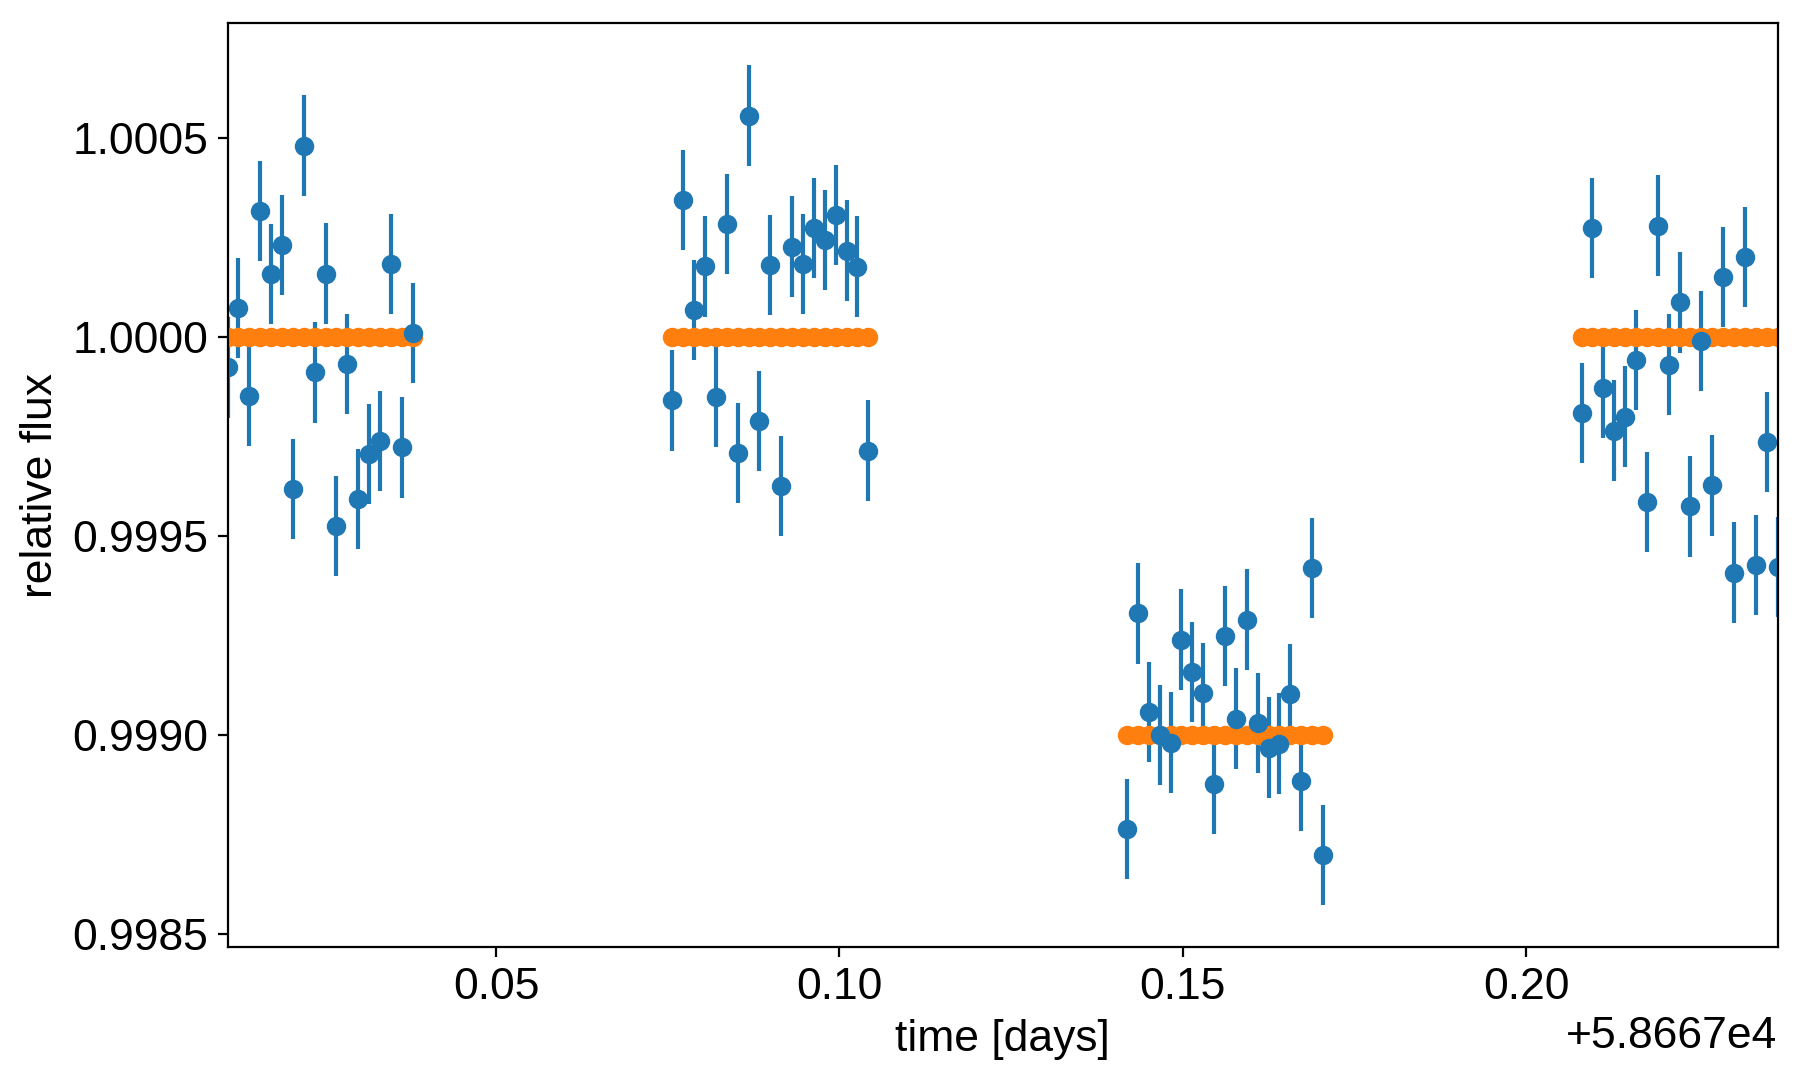

In [75]:
plt.rcParams['figure.figsize'] = (10,6)
plt.errorbar(times, flux * (injected_light_curves+1), yerr, fmt='o')
plt.plot(times, injected_light_curves+1,'o')
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.xlim(times.min(), times.max());

# Run 400 MCMCs

In [197]:
fine_snr_flux = planet.normed_photometry_df
fine_snr_uncs = planet.normed_uncertainty_df

n_columns = len(fine_snr_flux.columns)

aper_sum_columns = planet.normed_photometry_df.drop(
    ['xcenter', 'ycenter'], axis=1).columns

xcenters = planet.photometry_df['xcenter']
ycenters = planet.photometry_df['ycenter']
xcenters_mod = xcenters - np.median(xcenters)
ycenters_mod = ycenters - np.median(ycenters)
times_mod = times - t0_guess#np.median(times)

In [86]:
n_space = 2
near_best_apertures_NxN_small = [f'aperture_sum_{aper_width_}x{aper_height_}' 
                       for aper_width_ in (np.arange(-n_space+1,n_space)+fine_min_snr_aper_width)
                       for aper_height_ in (np.arange(-n_space+1,n_space)+fine_min_snr_aper_height)]

In [87]:
near_best_apertures_NxN_small,len(near_best_apertures_NxN_small)

(['aperture_sum_19x49',
  'aperture_sum_19x50',
  'aperture_sum_19x51',
  'aperture_sum_20x49',
  'aperture_sum_20x50',
  'aperture_sum_20x51',
  'aperture_sum_21x49',
  'aperture_sum_21x50',
  'aperture_sum_21x51'],
 9)

In [ ]:
plt.rcParams['figure.figsize'] = (10, 6)

tune = 3000
draws = 3000
target_accept = 0.9
do_mcmc = False
save_as_you_go = False

base_name = 'WASP43_fine_grain_photometry_208ppm'
base_name = f'{base_name}_near_best_{n_space}x{n_space}'
near_best_apertures_NxN_small = [fine_min_snr_colname]  # aper_sum_columns,  #

run_all_12_options(times,
                   fine_snr_flux,
                   fine_snr_uncs,
                   near_best_apertures_NxN_small,
                   xcenters_mod,
                   t0=t0_guess,
                   u=u,
                   period=period_wasp43,
                   b=b_wasp43,
                   idx_fwd=idx_fwd,
                   idx_rev=idx_rev,
                   tune=tune,
                   draws=draws,
                   target_accept=target_accept,
                   do_mcmc=do_mcmc,
                   save_as_you_go=save_as_you_go,
                   injected_light_curve=1.0,
                   working_dir=working_dir,
                   base_name=base_name)

In [ ]:
start0 = time()
# Linear Eclipse Depths with Negative Allowed
start1 = time()
print('Linear Eclipse depth fits - Allow Negative Eclipse Depths')
fine_grain_mcmcs, filename = run_multiple_pymc3(
    times, fine_snr_flux, fine_snr_uncs, near_best_apertures_NxN_small,
    t0=t0_guess, u=u, period=period_wasp43, b=b_wasp43,
    idx_fwd=idx_fwd, idx_rev=idx_rev,
    tune=tune, draws=draws, target_accept=target_accept,
    do_mcmc=do_mcmc, save_as_you_go=save_as_you_go,
    injected_light_curve=1.0, base_name=base_name, working_dir=working_dir,
    xcenters=None,
    allow_negative_edepths=True,
    use_rev_fwd_split=False,
    use_log_edepth=False
)

fine_grain_mcmcs_no_xcenter_lin_edepth_no_split_w_negEcl = fine_grain_mcmcs
filename_no_xcenter_lin_edepth_no_split_w_negEcl = filename
print(f'[INFO] This MCMCs took {(time() - start1)/60:0.2f} minutes')

del fine_grain_mcmcs, filename

start1 = time()
print('Linear Eclipse depth fits - Allow Negative Eclipse Depths with splitting fwd rev')
fine_grain_mcmcs, filename = run_multiple_pymc3(
    times, fine_snr_flux, fine_snr_uncs, near_best_apertures_NxN_small,
    t0=t0_guess, u=u, period=period_wasp43, b=b_wasp43,
    idx_fwd=idx_fwd, idx_rev=idx_rev,
    tune=tune, draws=draws, target_accept=target_accept,
    do_mcmc=do_mcmc, save_as_you_go=save_as_you_go,
    injected_light_curve=1.0, base_name=base_name, working_dir=working_dir,
    xcenters=None,  # SAME
    allow_negative_edepths=True,  # SAME
    use_rev_fwd_split=True,  # DIFFERENT
    use_log_edepth=False  # SAME
)
fine_grain_mcmcs_with_no_xcenter_lin_edepth_w_split_w_negEcl = fine_grain_mcmcs
filename_with_no_xcenter_lin_edepth_w_split_w_negEcl = filename

print(f'[INFO] This MCMCs took {(time() - start1)/60:0.2f} minutes')

del fine_grain_mcmcs, filename

start1 = time()
print('Linear Eclipse depth fits - Allow Negative Eclipse Depths with xcenter')
fine_grain_mcmcs, filename = run_multiple_pymc3(
    times, fine_snr_flux, fine_snr_uncs, near_best_apertures_NxN_small,
    t0=t0_guess, u=u, period=period_wasp43, b=b_wasp43,
    idx_fwd=idx_fwd, idx_rev=idx_rev,
    tune=tune, draws=draws, target_accept=target_accept,
    do_mcmc=do_mcmc, save_as_you_go=save_as_you_go,
    injected_light_curve=1.0, base_name=base_name, working_dir=working_dir,
    xcenters=xcenters_mod,  # DIFFERENT
    allow_negative_edepths=True,  # SAME
    use_rev_fwd_split=False,  # SAME
    use_log_edepth=False,  # SAME
)

fine_grain_mcmcs_with_w_xcenter_lin_edepth_no_split_w_negEcl = fine_grain_mcmcs
filename_with_w_xcenter_lin_edepth_no_split_w_negEcl = filename
print(f'[INFO] This MCMCs took {(time() - start1)/60:0.2f} minutes')

del fine_grain_mcmcs, filename

start1 = time()
print('Linear Eclipse depth fits - '
      'Allow Negative Eclipse Depths with xcenter and splitting fwd rev')
fine_grain_mcmcs, filename = run_multiple_pymc3(
    times, fine_snr_flux, fine_snr_uncs, near_best_apertures_NxN_small,
    t0=t0_guess, u=u, period=period_wasp43, b=b_wasp43,
    idx_fwd=idx_fwd, idx_rev=idx_rev,
    tune=tune, draws=draws, target_accept=target_accept,
    do_mcmc=do_mcmc, save_as_you_go=save_as_you_go,
    injected_light_curve=1.0, base_name=base_name, working_dir=working_dir,
    xcenters=xcenters_mod,  # SAME
    allow_negative_edepths=True,  # SAME
    use_rev_fwd_split=True,  # DIFFERENT
    use_log_edepth=False  # SAME
)

fine_grain_mcmcs_with_w_xcenter_lin_edepth_w_split_w_negEcl = fine_grain_mcmcs
filename_with_w_xcenter_lin_edepth_w_split_w_negEcl = filename
print(f'[INFO] This MCMCs took {(time() - start1)/60:0.2f} minutes')

del fine_grain_mcmcs, filename

start1 = time()
# Linear Eclipse Depths without Negative Allowed
print('Linear Eclipse depth fits - Default everything')
fine_grain_mcmcs, filename = run_multiple_pymc3(
    times, fine_snr_flux, fine_snr_uncs, near_best_apertures_NxN_small,
    t0=t0_guess, u=u, period=period_wasp43, b=b_wasp43, idx_fwd=idx_fwd, idx_rev=idx_rev,
    tune=tune, draws=draws, target_accept=target_accept,
    injected_light_curve=1.0, base_name=base_name, working_dir=working_dir,
    do_mcmc=do_mcmc, save_as_you_go=save_as_you_go,
    xcenters=None,  # DIFFERENT
    allow_negative_edepths=False,  # DIFFERENT
    use_rev_fwd_split=False,  # DIFFERENT
    use_log_edepth=False  # SAME
)

fine_grain_mcmcs_with_no_xcenter_lin_edepth_no_split = fine_grain_mcmcs
filename_with_no_xcenter_lin_edepth_no_split = filename
print(f'[INFO] This MCMCs took {(time() - start1)/60:0.2f} minutes')

del fine_grain_mcmcs, filename

start1 = time()
print('Linear Eclipse depth fits - Everything with splitting fwd rev')
fine_grain_mcmcs, filename = run_multiple_pymc3(
    times, fine_snr_flux, fine_snr_uncs, near_best_apertures_NxN_small,
    t0=t0_guess, u=u, period=period_wasp43, b=b_wasp43, idx_fwd=idx_fwd, idx_rev=idx_rev,
    tune=tune, draws=draws, target_accept=target_accept,
    injected_light_curve=1.0, base_name=base_name, working_dir=working_dir,
    do_mcmc=do_mcmc, save_as_you_go=save_as_you_go,
    xcenters=None,  # SAME
    allow_negative_edepths=False,  # SAME
    use_rev_fwd_split=True,  # DIFFERENT
    use_log_edepth=False,  # SAME
)

fine_grain_mcmcs_with_no_xcenter_lin_edepth_w_split = fine_grain_mcmcs
filename_with_no_xcenter_lin_edepth_w_split = filename

print(f'[INFO] This MCMCs took {(time() - start1)/60:0.2f} minutes')

del fine_grain_mcmcs, filename

start1 = time()
print('Linear Eclipse depth fits - Everything with xcenter')
fine_grain_mcmcs, filename = run_multiple_pymc3(
    times, fine_snr_flux, fine_snr_uncs, near_best_apertures_NxN_small,
    t0=t0_guess, u=u, period=period_wasp43, b=b_wasp43,
    idx_fwd=idx_fwd, idx_rev=idx_rev,
    tune=tune, draws=draws, target_accept=target_accept,
    do_mcmc=do_mcmc, save_as_you_go=save_as_you_go,
    injected_light_curve=1.0, base_name=base_name, working_dir=working_dir,
    xcenters=xcenters_mod,  # DIFFERENT
    allow_negative_edepths=False,  # SAME
    use_rev_fwd_split=False,  # DIFFERENT
    use_log_edepth=False  # SAME
)

fine_grain_mcmcs_with_w_xcenter_lin_edepth_no_split = fine_grain_mcmcs
filename_with_w_xcenter_lin_edepth_no_split = filename

print(f'[INFO] This MCMCs took {(time() - start1)/60:0.2f} minutes')

del fine_grain_mcmcs, filename

start1 = time()
print('Linear Eclipse depth fits - '
      'Everything with xcenter and splitting fwd rev')
fine_grain_mcmcs, filename = run_multiple_pymc3(
    times, fine_snr_flux, fine_snr_uncs, near_best_apertures_NxN_small,
    t0=t0_guess, u=u, period=period_wasp43, b=b_wasp43,
    idx_fwd=idx_fwd, idx_rev=idx_rev,
    tune=tune, draws=draws, target_accept=target_accept,
    do_mcmc=do_mcmc, save_as_you_go=save_as_you_go,
    injected_light_curve=1.0, base_name=base_name, working_dir=working_dir,
    xcenters=xcenters_mod,  # SAME
    allow_negative_edepths=False,  # SAME
    use_rev_fwd_split=True,  # DIFFERENT
    use_log_edepth=False)  # SAME

fine_grain_mcmcs_with_w_xcenter_lin_edepth_w_split = fine_grain_mcmcs
filename_with_w_xcenter_lin_edepth_w_split = filename

print(f'[INFO] This MCMCs took {(time() - start1)/60:0.2f} minutes')

del fine_grain_mcmcs, filename

# Logarithmic Eclipse Depths
start1 = time()
print('Log Eclipse depth fits - Default everything')
fine_grain_mcmcs, filename = run_multiple_pymc3(
    times, fine_snr_flux, fine_snr_uncs, near_best_apertures_NxN_small,
    t0=t0_guess, u=u, period=period_wasp43, b=b_wasp43,
    idx_fwd=idx_fwd, idx_rev=idx_rev,
    tune=tune, draws=draws, target_accept=target_accept,
    do_mcmc=do_mcmc, save_as_you_go=save_as_you_go,
    injected_light_curve=1.0, base_name=base_name, working_dir=working_dir,
    xcenters=None,  # DIFFERENT
    allow_negative_edepths=False,  # SAME
    use_rev_fwd_split=False,  # DIFFERENT
    use_log_edepth=True  # DIFFERENT
)

fine_grain_mcmcs_with_no_xcenter_log_edepth_no_split = fine_grain_mcmcs
filename_with_no_xcenter_log_edepth_no_split = filename

print(f'[INFO] This MCMCs took {(time() - start1)/60:0.2f} minutes')

del fine_grain_mcmcs, filename

start1 = time()
print('Log Eclipse depth fits - Everything with splitting fwd rev')
fine_grain_mcmcs, filename = run_multiple_pymc3(
    times, fine_snr_flux, fine_snr_uncs, near_best_apertures_NxN_small,
    t0=t0_guess, u=u, period=period_wasp43, b=b_wasp43,
    idx_fwd=idx_fwd, idx_rev=idx_rev,
    tune=tune, draws=draws, target_accept=target_accept,
    do_mcmc=do_mcmc, save_as_you_go=save_as_you_go,
    injected_light_curve=1.0, base_name=base_name, working_dir=working_dir,
    xcenters=None,  # SAME
    allow_negative_edepths=False,  # SAME
    use_rev_fwd_split=True,  # DIFFERENT
    use_log_edepth=True  # SAME
)

fine_grain_mcmcs_with_no_xcenter_log_edepth_w_split = fine_grain_mcmcs
filename_with_no_xcenter_log_edepth_w_split = filename

print(f'[INFO] This MCMCs took {(time() - start1)/60:0.2f} minutes')

start1 = time()
print('Log Eclipse depth fits - Everything with xcenter')
fine_grain_mcmcs, filename = run_multiple_pymc3(
    times, fine_snr_flux, fine_snr_uncs, near_best_apertures_NxN_small,
    t0=t0_guess, u=u, period=period_wasp43, b=b_wasp43,
    idx_fwd=idx_fwd, idx_rev=idx_rev,
    tune=tune, draws=draws, target_accept=target_accept,
    do_mcmc=do_mcmc, save_as_you_go=save_as_you_go,
    injected_light_curve=1.0, base_name=base_name, working_dir=working_dir,
    xcenters=xcenters_mod,  # DIFFERENT
    allow_negative_edepths=False,  # SAME
    use_rev_fwd_split=False,  # DIFFERENT
    use_log_edepth=True  # SAME
)

fine_grain_mcmcs_with_w_xcenter_log_edepth_no_split = fine_grain_mcmcs
filename_with_w_xcenter_log_edepth_no_split = filename

print(f'[INFO] This MCMCs took {(time() - start1)/60:0.2f} minutes')

del fine_grain_mcmcs, filename

start1 = time()
print('Log Eclipse depth fits - Everything with xcenter and splitting fwd rev')
fine_grain_mcmcs, filename = run_multiple_pymc3(
    times, fine_snr_flux, fine_snr_uncs, near_best_apertures_NxN_small,
    t0=t0_guess, u=u, period=period_wasp43, b=b_wasp43,
    idx_fwd=idx_fwd, idx_rev=idx_rev,
    tune=tune, draws=draws, target_accept=target_accept,
    do_mcmc=do_mcmc, save_as_you_go=save_as_you_go,
    injected_light_curve=1.0, base_name=base_name, working_dir=working_dir,
    xcenters=xcenters_mod,  # SAME
    allow_negative_edepths=False,  # SAME
    use_rev_fwd_split=True,  # DIFFERENT
    use_log_edepth=True  # SAME
)

fine_grain_mcmcs_with_w_xcenter_log_edepth_w_split = fine_grain_mcmcs
filename_with_w_xcenter_log_edepth_w_split = filename

print(f'[INFO] This MCMCs took {(time() - start1)/60:0.2f} minutes')

print(f'[INFO] All 12 MCMCs took {(time() - start0)/60:0.2f} minutes')

Linear Eclipse depth fits - Default everything
[INFO] Working on aperture_sum_19x49 for MAP/Trace MCMCs


optimizing logp for variables: [slope, edepth, mean]
23it [00:00, 63.72it/s, logp=4.401408e+02] 
message: Optimization terminated successfully.
logp: 433.98692842027975 -> 440.1408129153806


[INFO] map_soln_edepth:0.0


Multiprocess sampling (16 chains in 16 jobs)
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope, edepth, mean]
NUTS: [slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:47<00:00, 2032.02draws/s]


            mean        sd      mc_error   hpd_2.5  hpd_97.5         n_eff  \
mean    0.999975  0.000015  6.695634e-08  0.999945  1.000005  47053.033503   
edepth  0.000008  0.002005  9.030468e-06 -0.003833  0.003986  43565.666456   
slope  -0.000654  0.000198  8.812953e-07 -0.001044 -0.000265  47911.220575   

            Rhat  
mean    0.999998  
edepth  0.999966  
slope   0.999952  
[INFO] Completed aperture_sum_19x49 for Trace MCMCs took 64.98861646652222
[INFO] Working on aperture_sum_19x50 for MAP/Trace MCMCs


optimizing logp for variables: [slope, edepth, mean]
10it [00:00, 31.69it/s, logp=4.398946e+02]
message: Optimization terminated successfully.
logp: 433.7529697380361 -> 439.894640674598


[INFO] map_soln_edepth:0.0


Multiprocess sampling (16 chains in 16 jobs)
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope, edepth, mean]
NUTS: [slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:51<00:00, 1873.07draws/s]


            mean        sd      mc_error   hpd_2.5  hpd_97.5         n_eff  \
mean    0.999974  0.000015  6.760557e-08  0.999945  1.000004  45349.650691   
edepth -0.000007  0.001995  9.241938e-06 -0.003858  0.003876  44103.718526   
slope  -0.000653  0.000197  8.822897e-07 -0.001047 -0.000276  44957.481791   

            Rhat  
mean    1.000051  
edepth  1.000053  
slope   0.999997  
[INFO] Completed aperture_sum_19x50 for Trace MCMCs took 64.37107348442078
[INFO] Working on aperture_sum_19x51 for MAP/Trace MCMCs


optimizing logp for variables: [slope, edepth, mean]
10it [00:00, 30.56it/s, logp=4.392831e+02]
message: Optimization terminated successfully.
logp: 432.98728786947015 -> 439.28309709305694


[INFO] map_soln_edepth:0.0


Multiprocess sampling (16 chains in 16 jobs)
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope, edepth, mean]
NUTS: [slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:49<00:00, 1927.28draws/s]


            mean        sd      mc_error   hpd_2.5  hpd_97.5         n_eff  \
mean    0.999973  0.000015  6.835852e-08  0.999944  1.000003  46259.128200   
edepth -0.000006  0.002026  8.224902e-06 -0.003926  0.003925  46193.118166   
slope  -0.000658  0.000196  8.850448e-07 -0.001038 -0.000273  48521.998539   

            Rhat  
mean    0.999978  
edepth  0.999951  
slope   1.000052  
[INFO] Completed aperture_sum_19x51 for Trace MCMCs took 63.34128475189209
[INFO] Working on aperture_sum_20x49 for MAP/Trace MCMCs


optimizing logp for variables: [slope, edepth, mean]
10it [00:00, 31.19it/s, logp=4.402753e+02]
message: Optimization terminated successfully.
logp: 434.15023840631886 -> 440.2753115131236


[INFO] map_soln_edepth:0.0


Multiprocess sampling (16 chains in 16 jobs)
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope, edepth, mean]
NUTS: [slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:48<00:00, 1991.58draws/s]


            mean        sd      mc_error   hpd_2.5  hpd_97.5         n_eff  \
mean    0.999975  0.000015  6.690847e-08  0.999946  1.000005  48784.646726   
edepth -0.000001  0.002016  1.060257e-05 -0.003923  0.003926  45708.760855   
slope  -0.000657  0.000198  8.903329e-07 -0.001047 -0.000271  48941.412897   

            Rhat  
mean    1.000016  
edepth  1.000024  
slope   0.999928  
[INFO] Completed aperture_sum_20x49 for Trace MCMCs took 66.33727550506592
[INFO] Working on aperture_sum_20x50 for MAP/Trace MCMCs


optimizing logp for variables: [slope, edepth, mean]
10it [00:00, 26.66it/s, logp=4.400344e+02]
message: Optimization terminated successfully.
logp: 433.92095091680073 -> 440.0343705351348


[INFO] map_soln_edepth:0.0


Multiprocess sampling (16 chains in 16 jobs)
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope, edepth, mean]
NUTS: [slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:50<00:00, 1916.69draws/s]


            mean        sd      mc_error   hpd_2.5  hpd_97.5         n_eff  \
mean    0.999975  0.000015  6.752536e-08  0.999945  1.000004  45174.033641   
edepth  0.000005  0.001989  8.172792e-06 -0.003903  0.003830  45495.475467   
slope  -0.000655  0.000197  9.151768e-07 -0.001040 -0.000273  47544.822104   

            Rhat  
mean    1.000011  
edepth  0.999887  
slope   1.000020  
[INFO] Completed aperture_sum_20x50 for Trace MCMCs took 63.23952841758728
[INFO] Working on aperture_sum_20x51 for MAP/Trace MCMCs


optimizing logp for variables: [slope, edepth, mean]
10it [00:00, 31.75it/s, logp=4.394389e+02]
message: Optimization terminated successfully.
logp: 433.16837064020115 -> 439.43894604930165


[INFO] map_soln_edepth:0.0


Multiprocess sampling (16 chains in 16 jobs)
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope, edepth, mean]
NUTS: [slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:51<00:00, 1857.44draws/s]


            mean        sd      mc_error   hpd_2.5  hpd_97.5         n_eff  \
mean    0.999974  0.000015  7.821156e-08  0.999945  1.000004  45806.722004   
edepth -0.000009  0.002015  1.008337e-05 -0.003938  0.003896  45201.715083   
slope  -0.000661  0.000196  8.691303e-07 -0.001029 -0.000261  46320.467397   

            Rhat  
mean    1.000104  
edepth  1.000051  
slope   0.999971  
[INFO] Completed aperture_sum_20x51 for Trace MCMCs took 64.66032195091248
[INFO] Working on aperture_sum_21x49 for MAP/Trace MCMCs


optimizing logp for variables: [slope, edepth, mean]
10it [00:00, 33.47it/s, logp=4.397954e+02]
message: Optimization terminated successfully.
logp: 433.6628488540176 -> 439.79536321876634


[INFO] map_soln_edepth:0.0


Multiprocess sampling (16 chains in 16 jobs)
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope, edepth, mean]
NUTS: [slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:49<00:00, 1920.46draws/s]


            mean        sd      mc_error   hpd_2.5  hpd_97.5         n_eff  \
mean    0.999975  0.000015  8.066495e-08  0.999946  1.000005  44221.509792   
edepth -0.000001  0.002007  1.007140e-05 -0.003857  0.003988  43537.254318   
slope  -0.000656  0.000200  1.080226e-06 -0.001040 -0.000256  45905.768160   

            Rhat  
mean    1.000163  
edepth  0.999976  
slope   1.000224  
[INFO] Completed aperture_sum_21x49 for Trace MCMCs took 68.8421688079834
[INFO] Working on aperture_sum_21x50 for MAP/Trace MCMCs


optimizing logp for variables: [slope, edepth, mean]
10it [00:00, 27.39it/s, logp=4.395636e+02]
message: Optimization terminated successfully.
logp: 433.442468052187 -> 439.5635774938579


[INFO] map_soln_edepth:0.0


Multiprocess sampling (16 chains in 16 jobs)
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope, edepth, mean]
NUTS: [slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:52<00:00, 1812.08draws/s]


            mean        sd      mc_error   hpd_2.5  hpd_97.5         n_eff  \
mean    0.999975  0.000015  7.116835e-08  0.999945  1.000004  45600.663249   
edepth  0.000013  0.002027  9.315855e-06 -0.003874  0.003990  44509.446972   
slope  -0.000655  0.000197  8.998034e-07 -0.001041 -0.000273  46793.407719   

            Rhat  
mean    1.000049  
edepth  0.999907  
slope   0.999985  
[INFO] Completed aperture_sum_21x50 for Trace MCMCs took 67.12023997306824
[INFO] Working on aperture_sum_21x51 for MAP/Trace MCMCs


optimizing logp for variables: [slope, edepth, mean]
10it [00:00, 32.33it/s, logp=4.389728e+02]
message: Optimization terminated successfully.
logp: 432.6880059246854 -> 438.9728153859867


[INFO] map_soln_edepth:0.0


Multiprocess sampling (16 chains in 16 jobs)
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope, edepth, mean]
NUTS: [slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:52<00:00, 1831.22draws/s]


                mean        sd      mc_error   hpd_2.5  hpd_97.5  \
mean    9.999735e-01  0.000015  7.999223e-08  0.999944  1.000003   
edepth  1.186746e-08  0.002012  9.516319e-06 -0.003905  0.003934   
slope  -6.567956e-04  0.000198  8.552801e-07 -0.001045 -0.000267   

               n_eff      Rhat  
mean    42717.518645  1.000062  
edepth  44948.226250  0.999940  
slope   46083.007323  1.000031  
[INFO] Completed aperture_sum_21x51 for Trace MCMCs took 65.4341607093811
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_208ppm_near_best_2x2_MCMCs_w_MAPS_no_fwd_rev_split_with_no_xcenter_fit_linear_edepth_allow_neg_edepth.joblib.save
[INFO] This MCMCs took 10.35 minutes
Linear Eclipse depth fits - Everything with splitting fwd rev
[INFO] Working on aperture_sum_19x49 for MAP/Trace MCMCs


optimizing logp for variables: [slope, edepth, mean_rev, mean_fwd]
13it [00:00, 29.14it/s, logp=5.037164e+02] 
message: Optimization terminated successfully.
logp: 433.0679898870749 -> 503.71644593907627


[INFO] map_soln_edepth:0.0


Multiprocess sampling (16 chains in 16 jobs)
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope, edepth, mean_rev, mean_fwd]
NUTS: [slope, edepth, mean_rev, mean_fwd]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:13<00:00, 1298.75draws/s]


              mean        sd      mc_error   hpd_2.5  hpd_97.5         n_eff  \
mean_fwd  0.999816  0.000021  1.031556e-07  0.999775  0.999856  45109.157930   
mean_rev  1.000147  0.000022  8.823240e-08  1.000105  1.000189  46226.289477   
edepth    0.000018  0.002002  1.000807e-05 -0.003759  0.004063  43893.328251   
slope    -0.000623  0.000197  9.322615e-07 -0.001009 -0.000241  47296.933730   

              Rhat  
mean_fwd  1.000097  
mean_rev  0.999989  
edepth    1.000013  
slope     0.999943  
[INFO] Completed aperture_sum_19x49 for Trace MCMCs took 108.27828669548035
[INFO] Working on aperture_sum_19x50 for MAP/Trace MCMCs


optimizing logp for variables: [slope, edepth, mean_rev, mean_fwd]
13it [00:00, 31.11it/s, logp=5.038344e+02] 
message: Optimization terminated successfully.
logp: 432.8340312048312 -> 503.83443213197484


[INFO] map_soln_edepth:0.0


Multiprocess sampling (16 chains in 16 jobs)
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope, edepth, mean_rev, mean_fwd]
NUTS: [slope, edepth, mean_rev, mean_fwd]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:11<00:00, 1334.54draws/s]


              mean        sd      mc_error   hpd_2.5  hpd_97.5         n_eff  \
mean_fwd  0.999815  0.000021  9.948664e-08  0.999774  0.999855  45862.375369   
mean_rev  1.000148  0.000021  8.915976e-08  1.000105  1.000189  47451.321917   
edepth    0.000004  0.002005  1.031168e-05 -0.003963  0.003842  43648.286706   
slope    -0.000620  0.000197  9.091465e-07 -0.001010 -0.000241  47535.858207   

              Rhat  
mean_fwd  1.000052  
mean_rev  0.999916  
edepth    1.000004  
slope     0.999942  
[INFO] Completed aperture_sum_19x50 for Trace MCMCs took 102.1707193851471
[INFO] Working on aperture_sum_19x51 for MAP/Trace MCMCs


optimizing logp for variables: [slope, edepth, mean_rev, mean_fwd]
13it [00:00, 30.89it/s, logp=5.035879e+02] 
message: Optimization terminated successfully.
logp: 432.0683493362655 -> 503.58794965180664


[INFO] map_soln_edepth:0.0


Multiprocess sampling (16 chains in 16 jobs)
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope, edepth, mean_rev, mean_fwd]
NUTS: [slope, edepth, mean_rev, mean_fwd]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:13<00:00, 1314.99draws/s]


                  mean        sd      mc_error   hpd_2.5  hpd_97.5  \
mean_fwd  9.998138e-01  0.000020  9.127871e-08  0.999774  0.999854   
mean_rev  1.000147e+00  0.000021  1.065068e-07  1.000107  1.000189   
edepth   -3.722137e-08  0.002001  9.034404e-06 -0.003917  0.003843   
slope    -6.237039e-04  0.000197  8.340491e-07 -0.001020 -0.000248   

                 n_eff      Rhat  
mean_fwd  47901.382705  1.000034  
mean_rev  46810.213676  1.000156  
edepth    47893.149663  0.999958  
slope     47744.523620  0.999917  
[INFO] Completed aperture_sum_19x51 for Trace MCMCs took 103.97977018356323
[INFO] Working on aperture_sum_20x49 for MAP/Trace MCMCs


optimizing logp for variables: [slope, edepth, mean_rev, mean_fwd]
13it [00:00, 30.34it/s, logp=5.037435e+02] 
message: Optimization terminated successfully.
logp: 433.2312998731144 -> 503.74353517358026


[INFO] map_soln_edepth:0.0


Multiprocess sampling (16 chains in 16 jobs)
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope, edepth, mean_rev, mean_fwd]
NUTS: [slope, edepth, mean_rev, mean_fwd]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:16<00:00, 1254.74draws/s]


              mean        sd      mc_error   hpd_2.5  hpd_97.5         n_eff  \
mean_fwd  0.999817  0.000021  9.717133e-08  0.999776  0.999857  46469.038882   
mean_rev  1.000148  0.000021  1.025129e-07  1.000106  1.000190  46392.920405   
edepth    0.000005  0.002000  1.065505e-05 -0.003805  0.004005  46091.238696   
slope    -0.000625  0.000198  1.005685e-06 -0.001017 -0.000239  46949.698277   

              Rhat  
mean_fwd  1.000019  
mean_rev  1.000043  
edepth    1.000078  
slope     1.000112  
[INFO] Completed aperture_sum_20x49 for Trace MCMCs took 107.10697197914124
[INFO] Working on aperture_sum_20x50 for MAP/Trace MCMCs


optimizing logp for variables: [slope, edepth, mean_rev, mean_fwd]
13it [00:00, 32.15it/s, logp=5.038679e+02] 
message: Optimization terminated successfully.
logp: 433.0020123835959 -> 503.86788288731566


[INFO] map_soln_edepth:0.0


Multiprocess sampling (16 chains in 16 jobs)
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope, edepth, mean_rev, mean_fwd]
NUTS: [slope, edepth, mean_rev, mean_fwd]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:13<00:00, 1300.17draws/s]


              mean        sd      mc_error   hpd_2.5  hpd_97.5         n_eff  \
mean_fwd  0.999816  0.000021  9.505149e-08  0.999776  0.999856  46036.354394   
mean_rev  1.000148  0.000021  1.131657e-07  1.000106  1.000190  45619.088534   
edepth    0.000004  0.001994  8.953492e-06 -0.003845  0.003921  45230.240874   
slope    -0.000623  0.000198  1.007757e-06 -0.001010 -0.000233  45425.730558   

              Rhat  
mean_fwd  1.000025  
mean_rev  1.000116  
edepth    1.000031  
slope     0.999989  
[INFO] Completed aperture_sum_20x50 for Trace MCMCs took 98.44535970687866
[INFO] Working on aperture_sum_20x51 for MAP/Trace MCMCs


optimizing logp for variables: [slope, edepth, mean_rev, mean_fwd]
13it [00:00, 30.56it/s, logp=5.036352e+02] 
message: Optimization terminated successfully.
logp: 432.2494321069964 -> 503.63523831233033


[INFO] map_soln_edepth:0.0


Multiprocess sampling (16 chains in 16 jobs)
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope, edepth, mean_rev, mean_fwd]
NUTS: [slope, edepth, mean_rev, mean_fwd]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:14<00:00, 1289.87draws/s]


              mean        sd      mc_error   hpd_2.5  hpd_97.5         n_eff  \
mean_fwd  0.999815  0.000020  9.474974e-08  0.999774  0.999854  46047.961350   
mean_rev  1.000148  0.000021  9.898550e-08  1.000106  1.000190  46337.525182   
edepth    0.000003  0.001993  9.553646e-06 -0.003974  0.003795  45495.196471   
slope    -0.000627  0.000197  8.550126e-07 -0.001014 -0.000242  45368.919326   

              Rhat  
mean_fwd  1.000043  
mean_rev  1.000016  
edepth    1.000086  
slope     0.999970  
[INFO] Completed aperture_sum_20x51 for Trace MCMCs took 105.56993174552917
[INFO] Working on aperture_sum_21x49 for MAP/Trace MCMCs


optimizing logp for variables: [slope, edepth, mean_rev, mean_fwd]
13it [00:00, 31.29it/s, logp=5.036125e+02] 
message: Optimization terminated successfully.
logp: 432.7439103208128 -> 503.6125165780518


[INFO] map_soln_edepth:0.0


Multiprocess sampling (16 chains in 16 jobs)
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope, edepth, mean_rev, mean_fwd]
NUTS: [slope, edepth, mean_rev, mean_fwd]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:12<00:00, 1323.15draws/s]


              mean        sd      mc_error   hpd_2.5  hpd_97.5         n_eff  \
mean_fwd  0.999816  0.000021  1.046980e-07  0.999775  0.999856  46767.108217   
mean_rev  1.000148  0.000021  1.129777e-07  1.000107  1.000191  45189.615356   
edepth   -0.000015  0.001997  9.822941e-06 -0.003905  0.003873  44234.202254   
slope    -0.000624  0.000198  9.770004e-07 -0.001008 -0.000236  45596.347881   

              Rhat  
mean_fwd  1.000041  
mean_rev  0.999996  
edepth    0.999997  
slope     1.000039  
[INFO] Completed aperture_sum_21x49 for Trace MCMCs took 103.97088193893433
[INFO] Working on aperture_sum_21x50 for MAP/Trace MCMCs


optimizing logp for variables: [slope, edepth, mean_rev, mean_fwd]
13it [00:00, 30.39it/s, logp=5.037436e+02] 
message: Optimization terminated successfully.
logp: 432.52352951898257 -> 503.74358105340707


[INFO] map_soln_edepth:0.0


Multiprocess sampling (16 chains in 16 jobs)
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope, edepth, mean_rev, mean_fwd]
NUTS: [slope, edepth, mean_rev, mean_fwd]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:16<00:00, 1260.27draws/s]


              mean        sd      mc_error   hpd_2.5  hpd_97.5         n_eff  \
mean_fwd  0.999815  0.000021  9.548524e-08  0.999775  0.999855  44996.227135   
mean_rev  1.000148  0.000021  1.045088e-07  1.000106  1.000190  47419.936057   
edepth    0.000007  0.002007  9.146245e-06 -0.003887  0.003884  46237.010032   
slope    -0.000620  0.000197  8.267122e-07 -0.001005 -0.000235  47193.413602   

              Rhat  
mean_fwd  0.999992  
mean_rev  0.999983  
edepth    1.000009  
slope     0.999928  
[INFO] Completed aperture_sum_21x50 for Trace MCMCs took 108.15877914428711
[INFO] Working on aperture_sum_21x51 for MAP/Trace MCMCs


optimizing logp for variables: [slope, edepth, mean_rev, mean_fwd]
13it [00:00, 28.20it/s, logp=5.035145e+02] 
message: Optimization terminated successfully.
logp: 431.7690673914807 -> 503.5145240970528


[INFO] map_soln_edepth:0.0


Multiprocess sampling (16 chains in 16 jobs)
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope, edepth, mean_rev, mean_fwd]
NUTS: [slope, edepth, mean_rev, mean_fwd]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:14<00:00, 1294.23draws/s]


              mean        sd      mc_error   hpd_2.5  hpd_97.5         n_eff  \
mean_fwd  0.999814  0.000020  8.966012e-08  0.999774  0.999854  47627.821040   
mean_rev  1.000148  0.000021  9.852410e-08  1.000105  1.000189  47299.987010   
edepth   -0.000005  0.002001  8.883510e-06 -0.003961  0.003851  45894.697853   
slope    -0.000624  0.000199  9.637613e-07 -0.001010 -0.000229  47641.039440   

              Rhat  
mean_fwd  1.000016  
mean_rev  1.000028  
edepth    1.000030  
slope     0.999897  
[INFO] Completed aperture_sum_21x51 for Trace MCMCs took 107.04200053215027
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_208ppm_near_best_2x2_MCMCs_w_MAPS_w_fwd_rev_split_with_no_xcenter_fit_linear_edepth_allow_neg_edepth.joblib.save
[INFO] This MCMCs took 16.52 minutes
Linear Eclipse depth fits - Everything with xcenter
[INFO] Working on aperture_sum_19x49 for MAP/Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
13it [00:00, 37.38it/s, logp=5.205199e+02] 
message: Optimization terminated successfully.
logp: 432.60063405915986 -> 520.5199496054474


[INFO] map_soln_edepth:0.0


Multiprocess sampling (16 chains in 16 jobs)
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
NUTS: [slope_xcenter, slope, edepth, mean]


In [93]:
filename_with_w_xcenter_log_edepth_w_split

'/home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_208ppm_near_best_2x2_MCMCs_w_MAPS_w_fwd_rev_split_with_fit_xcenter_fit_log_edepth.joblib.save'

In [168]:
mcmc_fits = [fine_grain_mcmcs_with_no_xcenter_lin_edepth_no_split_w_negEcl,
             fine_grain_mcmcs_with_no_xcenter_lin_edepth_w_split_w_negEcl,
             fine_grain_mcmcs_with_w_xcenter_lin_edepth_no_split_w_negEcl,
             fine_grain_mcmcs_with_w_xcenter_lin_edepth_w_split_w_negEcl,
             fine_grain_mcmcs_with_no_xcenter_lin_edepth_no_split,
             fine_grain_mcmcs_with_no_xcenter_lin_edepth_w_split,
             fine_grain_mcmcs_with_w_xcenter_lin_edepth_no_split,
             fine_grain_mcmcs_with_w_xcenter_lin_edepth_w_split,
             fine_grain_mcmcs_with_no_xcenter_log_edepth_no_split,
             fine_grain_mcmcs_with_no_xcenter_log_edepth_w_split,
             fine_grain_mcmcs_with_w_xcenter_log_edepth_no_split,
             fine_grain_mcmcs_with_w_xcenter_log_edepth_w_split
            ]

Parameter('slope', value=0.0009012628325032298) Parameter('slope', value=-0.0006603798859357084) Parameter('slope_x', value=0.0011024753183233658) Parameter('slope_y', value=-0.0018542590669552003) Parameter('intercept', value=-3.3767669200067854e-05) Parameter('intercept', value=0.9999739787290478) Parameter('intercept', value=0.999911951873828)


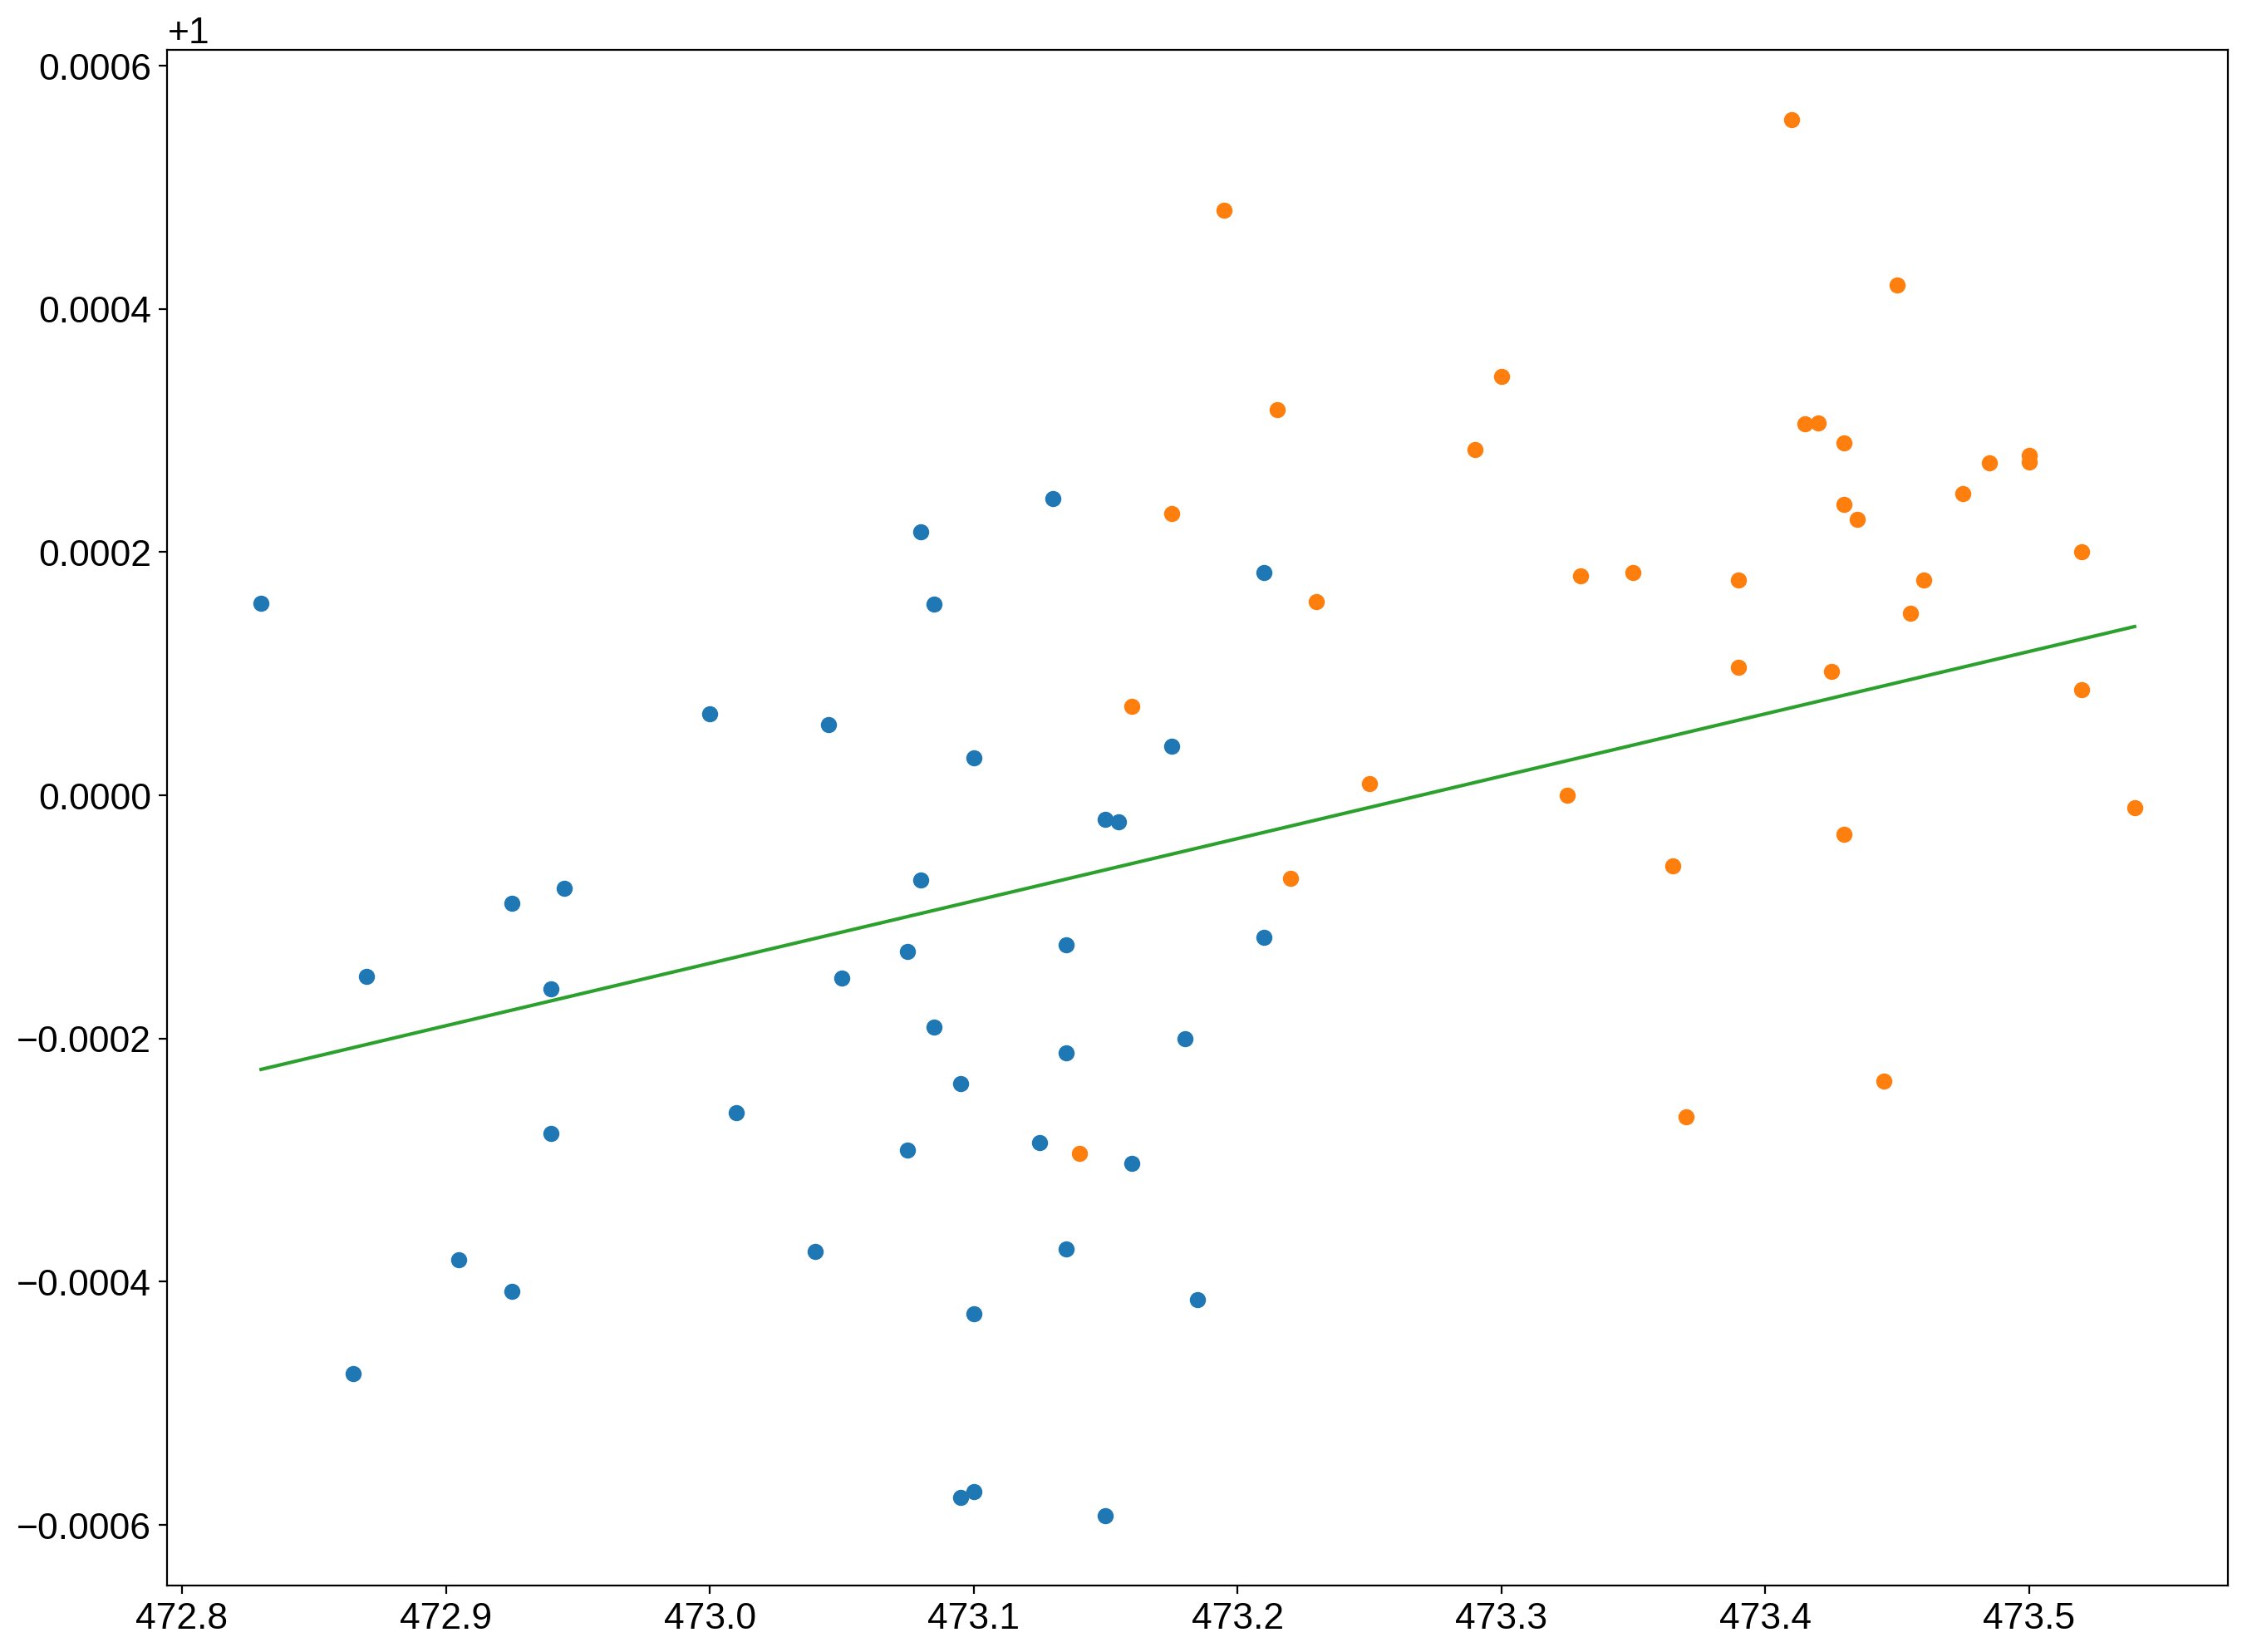

In [196]:
from astropy.modeling.models import Planar2D, Linear1D
from astropy.modeling.fitting import LinearLSQFitter

fitter_xc = LinearLSQFitter()
fitter_t = LinearLSQFitter()

model_xc =  Linear1D(slope=1e-3, intercept=np.median(planet.normed_photometry_df[fine_min_snr_colname]))
model_t =  Linear1D(slope=-1e-3, intercept=0)

fit_t = fitter_t(model_t, times - np.median(times), planet.normed_photometry_df[fine_min_snr_colname])
fit_xc = fitter_xc(model_xc, xcenters - np.median(xcenters), planet.normed_photometry_df[fine_min_snr_colname] - fit_t(times - np.median(times)))

model_comb = Planar2D(slope_x=fit_xc.slope, slope_y=fit_t.slope, intercept=fit_t.intercept)
fit_comb = fitter_t(model_comb, xcenters - np.median(xcenters), times - np.median(times), planet.normed_photometry_df[fine_min_snr_colname])
print(fit_xc.slope, fit_t.slope, fit_comb.slope_x, fit_comb.slope_y, fit_xc.intercept, fit_t.intercept, fit_comb.intercept)

plt.rcParams['figure.figsize'] = (16,12)
min_x = xcenters.min()
max_x = xcenters.max()
min_t = times.min() - np.median(times)
max_t = times.max() - np.median(times)
plt.plot(xcenters[idx_fwd], planet.normed_photometry_df[fine_min_snr_colname][idx_fwd], 'o')
plt.plot(xcenters[idx_rev], planet.normed_photometry_df[fine_min_snr_colname][idx_rev], 'o')

xcenters_th = np.linspace(min_x, max_x, 100)
times_th = np.linspace(min_t, max_t, 100)
plt.plot(xcenters_th, fit_comb(xcenters_th - np.median(xcenters), times_th))

Parameter('slope', value=0.0005458768522773404) Parameter('slope', value=-0.0006603798859357084) Parameter('slope_x', value=0.0018997082241179058) Parameter('slope_y', value=-0.002010719179453484) Parameter('intercept', value=1.3062222422967144e-05) Parameter('intercept', value=0.9999739787290478) Parameter('intercept', value=0.9999960008358373)


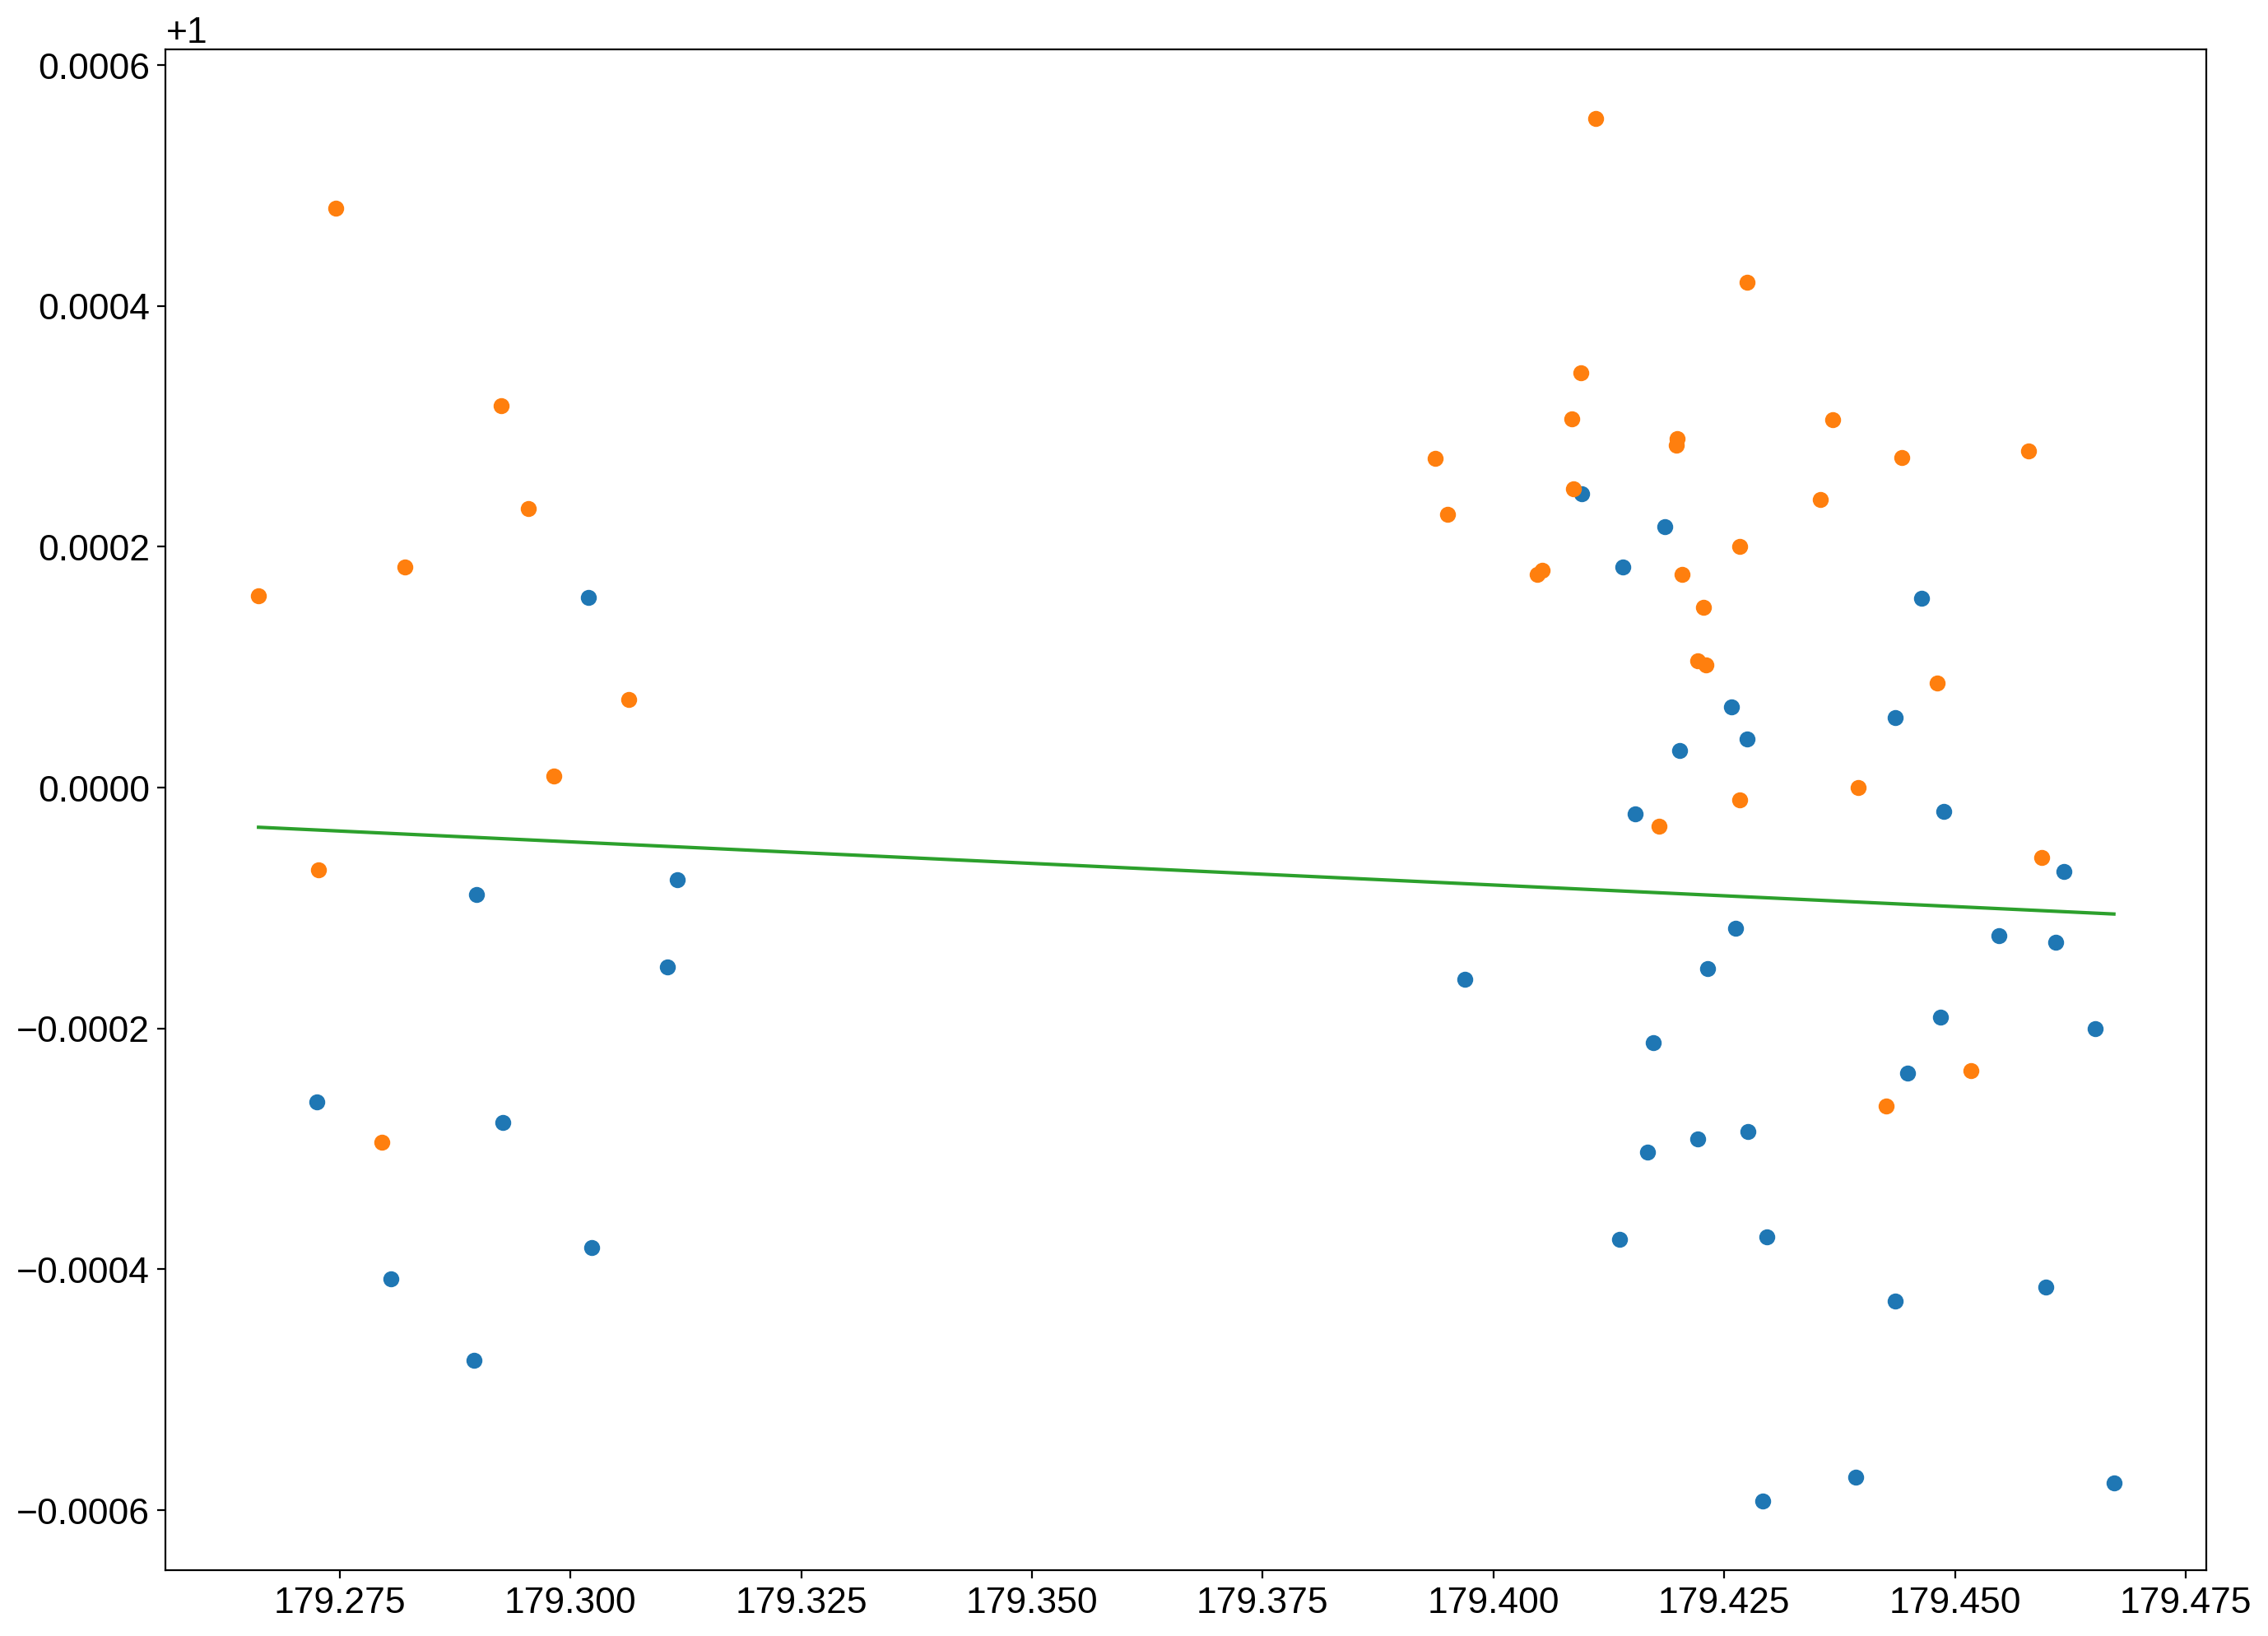

In [198]:
from astropy.modeling.models import Planar2D, Linear1D
from astropy.modeling.fitting import LinearLSQFitter

fitter_yc = LinearLSQFitter()
fitter_t = LinearLSQFitter()

model_yc =  Linear1D(slope=1e-3, intercept=np.median(planet.normed_photometry_df[fine_min_snr_colname]))
model_t =  Linear1D(slope=-1e-3, intercept=0)

fit_t = fitter_t(model_t, times - np.median(times), planet.normed_photometry_df[fine_min_snr_colname])
fit_yc = fitter_yc(model_yc, ycenters - np.median(ycenters), planet.normed_photometry_df[fine_min_snr_colname] - fit_t(times - np.median(times)))

model_comb = Planar2D(slope_x=fit_yc.slope, slope_y=fit_t.slope, intercept=fit_t.intercept)
fit_comb = fitter_t(model_comb, ycenters - np.median(ycenters), times - np.median(times), planet.normed_photometry_df[fine_min_snr_colname])
print(fit_yc.slope, fit_t.slope, fit_comb.slope_x, fit_comb.slope_y, fit_yc.intercept, fit_t.intercept, fit_comb.intercept)

plt.rcParams['figure.figsize'] = (16,12)
min_y = ycenters.min()
max_y = ycenters.max()
min_t = times.min() - np.median(times)
max_t = times.max() - np.median(times)
plt.plot(ycenters[idx_fwd], planet.normed_photometry_df[fine_min_snr_colname][idx_fwd], 'o')
plt.plot(ycenters[idx_rev], planet.normed_photometry_df[fine_min_snr_colname][idx_rev], 'o')

ycenters_th = np.linspace(min_y, max_y, 100)
times_th = np.linspace(min_t, max_t, 100)
plt.plot(ycenters_th, fit_comb(ycenters_th - np.median(ycenters), times_th))

Parameter('slope', value=0.0009322770106570888) Parameter('slope', value=-0.0006603798859357084) Parameter('slope_x', value=0.0009379750649591399) Parameter('slope_y', value=-0.0004998789347599011) Parameter('intercept', value=1.2554795760029172e-05) Parameter('intercept', value=0.9999739787290478) Parameter('intercept', value=0.9999893958303746)


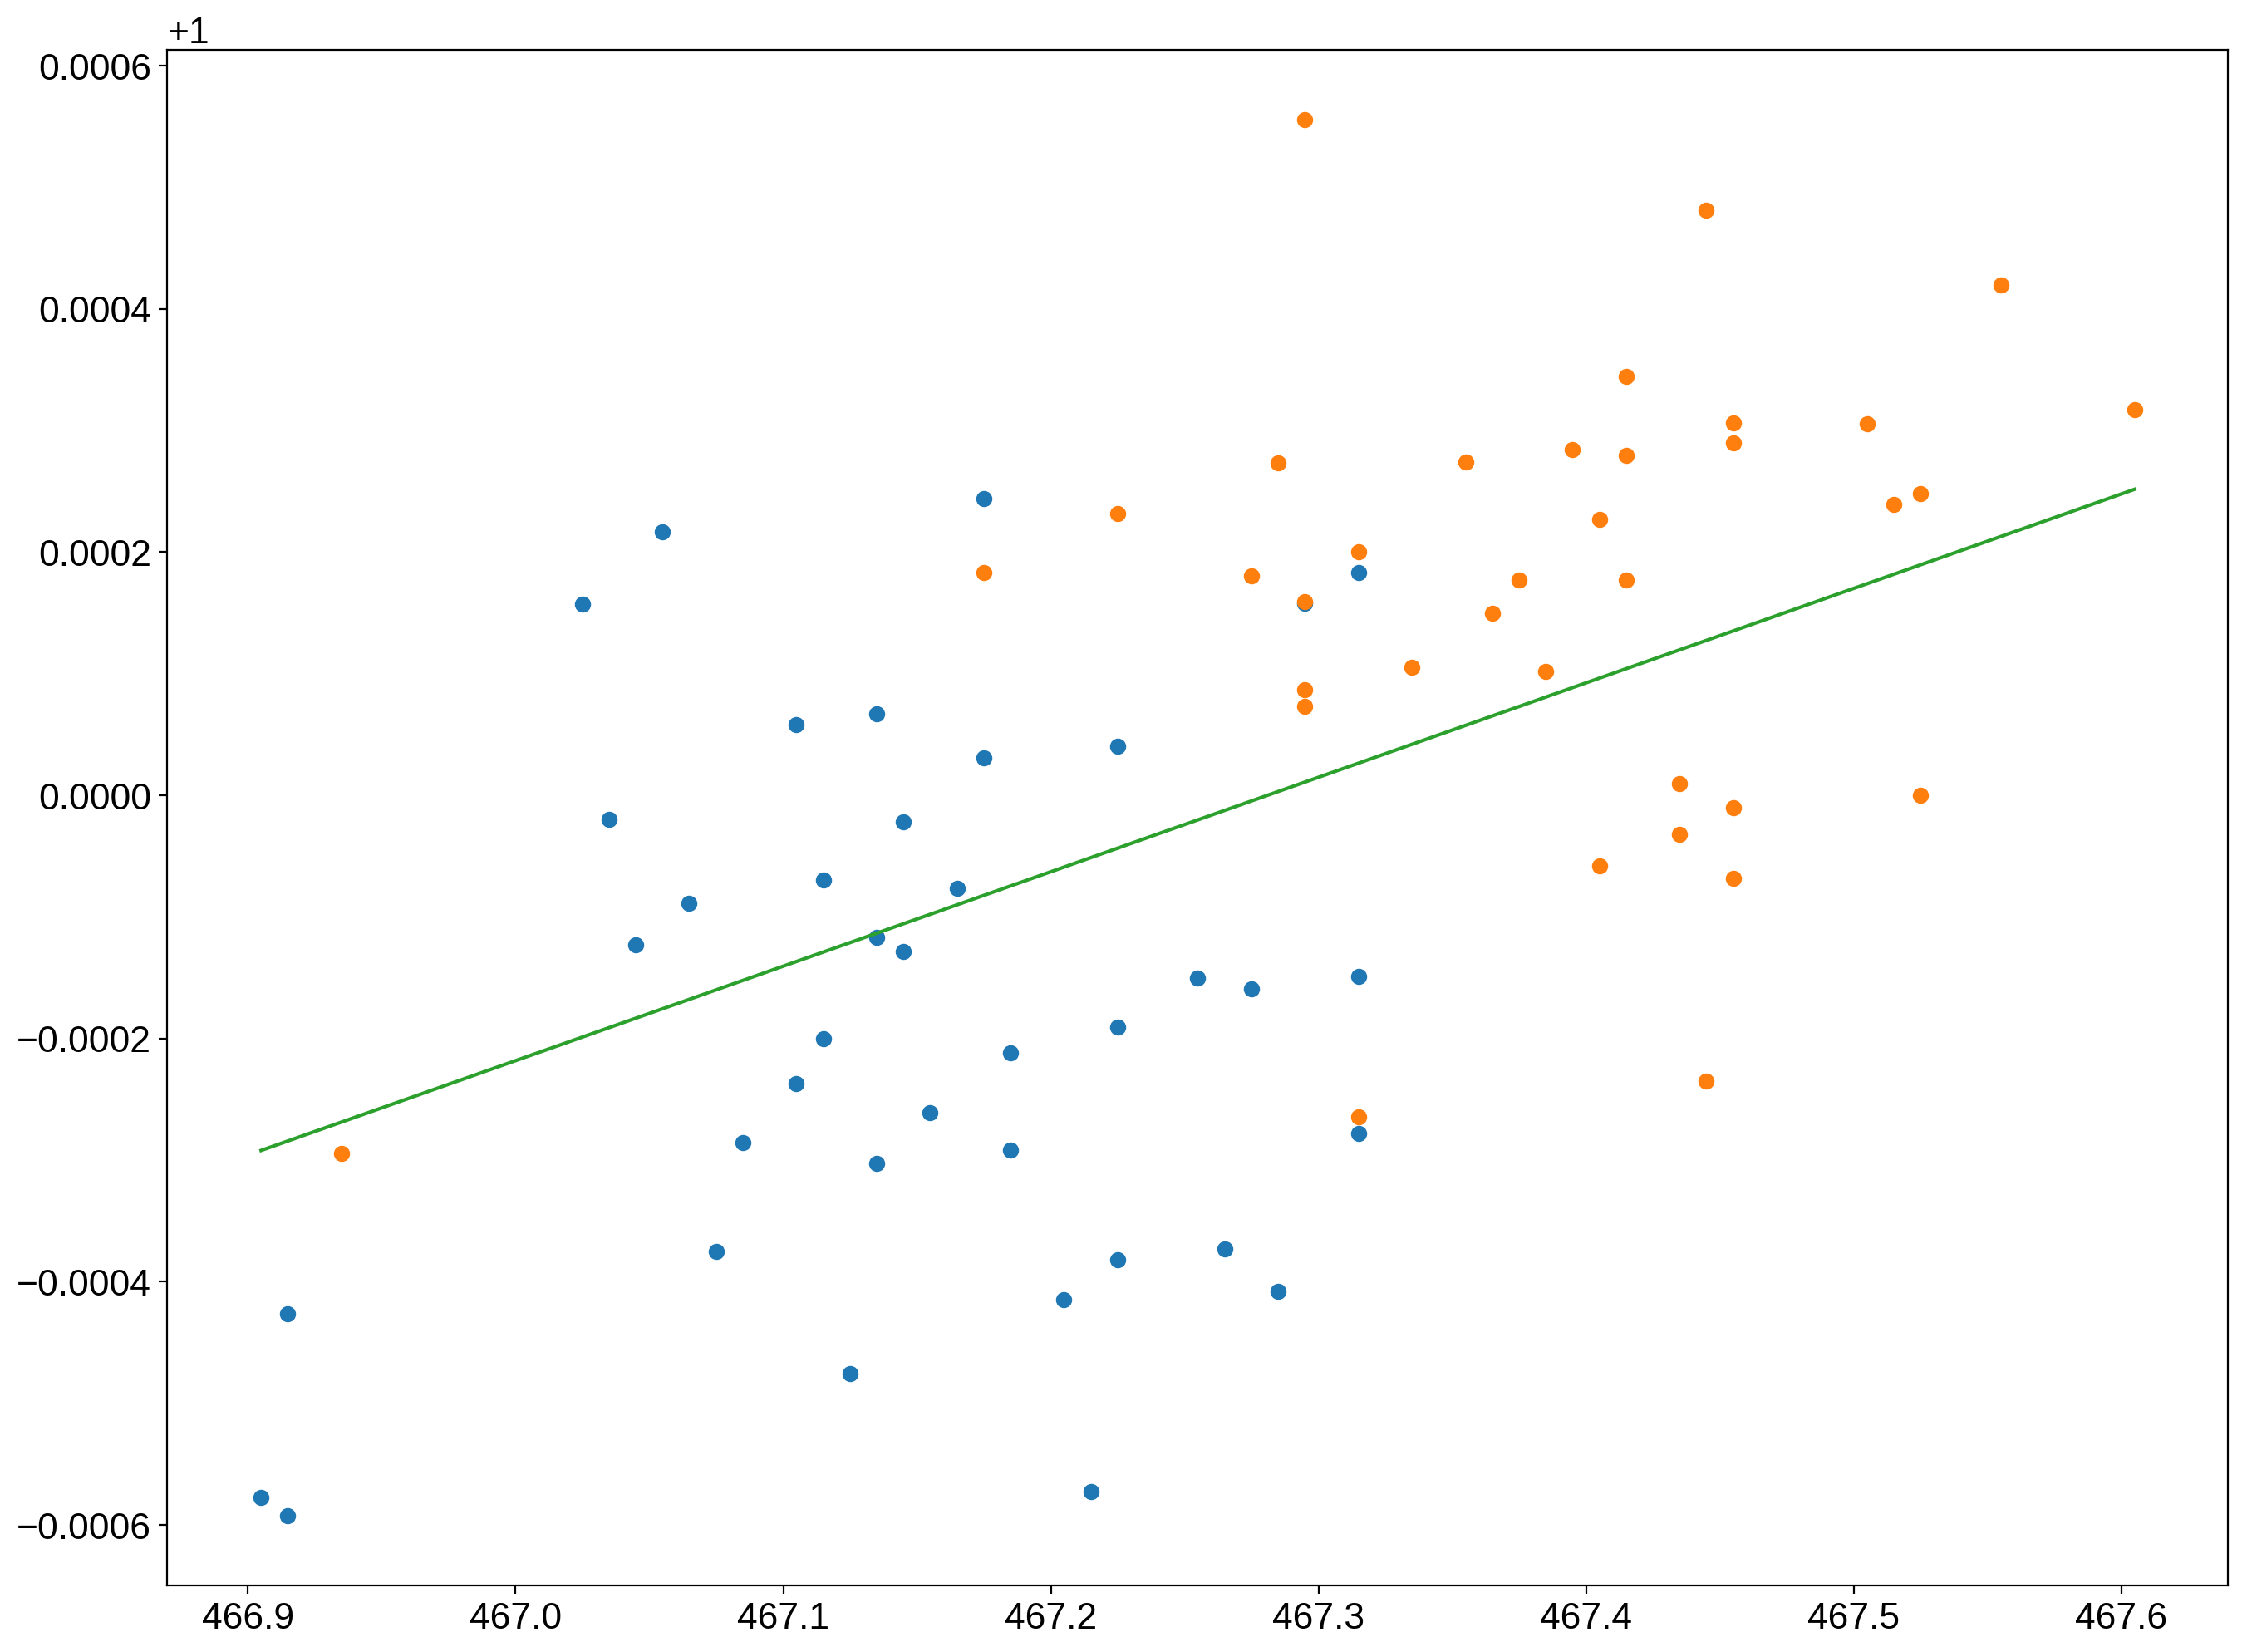

In [253]:
from astropy.modeling.models import Planar2D, Linear1D
from astropy.modeling.fitting import LinearLSQFitter

trace_lengths = planet.trace_lengths
fitter_yc = LinearLSQFitter()
fitter_t = LinearLSQFitter()

model_yc =  Linear1D(slope=1e-3, intercept=np.median(planet.normed_photometry_df[fine_min_snr_colname]))
model_t =  Linear1D(slope=-1e-3, intercept=0)

fit_t = fitter_t(model_t, times - np.median(times), planet.normed_photometry_df[fine_min_snr_colname])
fit_yc = fitter_yc(model_yc, trace_lengths - np.median(trace_lengths), planet.normed_photometry_df[fine_min_snr_colname] - fit_t(times - np.median(times)))

model_comb = Planar2D(slope_x=fit_yc.slope, slope_y=fit_t.slope, intercept=fit_t.intercept)
fit_comb = fitter_t(model_comb, trace_lengths - np.median(trace_lengths), times - np.median(times), planet.normed_photometry_df[fine_min_snr_colname])
print(fit_yc.slope, fit_t.slope, fit_comb.slope_x, fit_comb.slope_y, fit_yc.intercept, fit_t.intercept, fit_comb.intercept)

plt.rcParams['figure.figsize'] = (16,12)
min_y = trace_lengths.min()
max_y = trace_lengths.max()
min_t = times.min() - np.median(times)
max_t = times.max() - np.median(times)
plt.plot(trace_lengths[idx_fwd], planet.normed_photometry_df[fine_min_snr_colname][idx_fwd], 'o')
plt.plot(trace_lengths[idx_rev], planet.normed_photometry_df[fine_min_snr_colname][idx_rev], 'o')

trace_lengths_th = np.linspace(min_y, max_y, 100)
times_th = np.linspace(min_t, max_t, 100)
plt.plot(trace_lengths_th, fit_comb(trace_lengths_th - np.median(trace_lengths), times_th))

Parameter('slope', value=-0.6591680264117195) Parameter('slope', value=-0.0006603798859357084) Parameter('slope_x', value=-0.662147682169046) Parameter('slope_y', value=-0.0006283113060887243) Parameter('intercept', value=3.6348568691557802e-06) Parameter('intercept', value=0.9999739787290478) Parameter('intercept', value=0.9999781865822418)


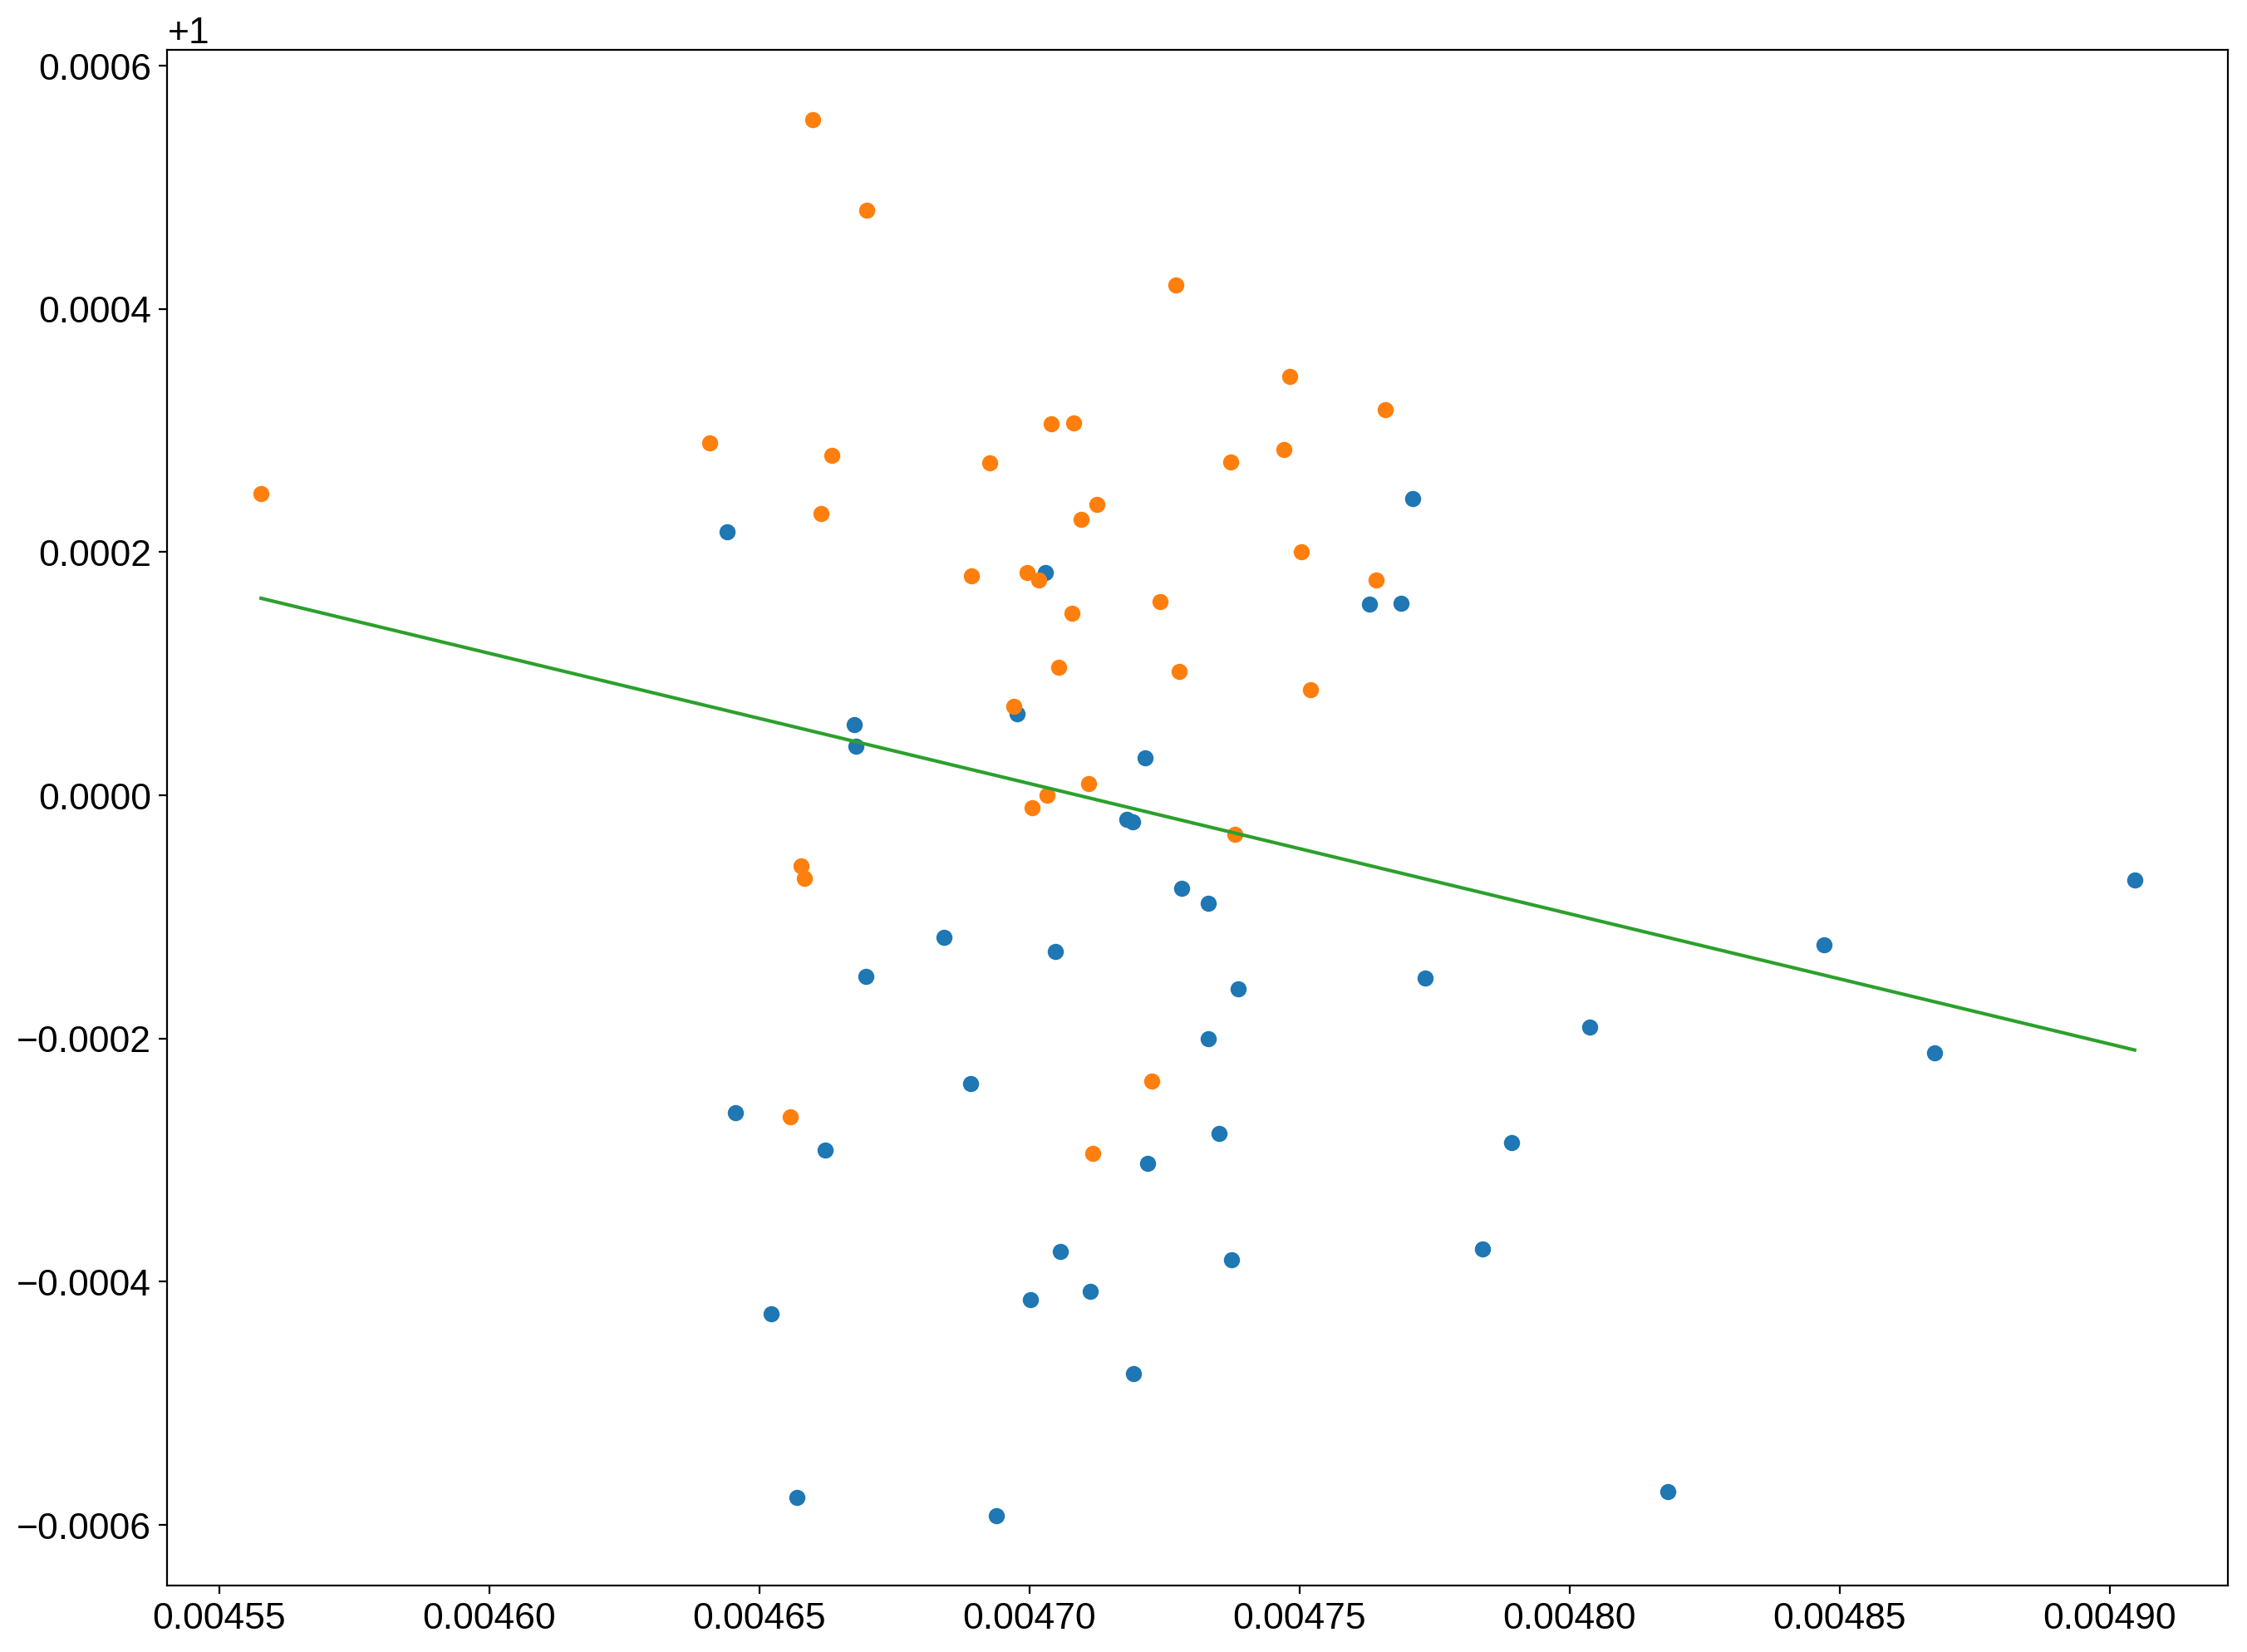

In [254]:
from astropy.modeling.models import Planar2D, Linear1D
from astropy.modeling.fitting import LinearLSQFitter

def fit_2D_time_vs_other(times, flux, other)
    fitter_o = LinearLSQFitter()
    fitter_t = LinearLSQFitter()

    model_yc =  Linear1D(slope=1e-3, intercept=np.median(flux))
    model_t =  Linear1D(slope=-1e-3, intercept=0)

    fit_t = fitter_t(model_t, times - np.median(times), planet.normed_photometry_df[fine_min_snr_colname])
    fit_yc = fitter_yc(model_yc, trace_angles - np.median(trace_angles), planet.normed_photometry_df[fine_min_snr_colname] - fit_t(times - np.median(times)))

    model_comb = Planar2D(slope_x=fit_yc.slope, slope_y=fit_t.slope, intercept=fit_t.intercept)
    fit_comb = fitter_t(model_comb, trace_angles - np.median(trace_angles), times - np.median(times), planet.normed_photometry_df[fine_min_snr_colname])
    print(fit_yc.slope, fit_t.slope, fit_comb.slope_x, fit_comb.slope_y, fit_yc.intercept, fit_t.intercept, fit_comb.intercept)

    plt.rcParams['figure.figsize'] = (16,12)
    min_y = trace_angles.min()
    max_y = trace_angles.max()
    min_t = times.min() - np.median(times)
    max_t = times.max() - np.median(times)
    plt.plot(trace_angles[idx_fwd], planet.normed_photometry_df[fine_min_snr_colname][idx_fwd], 'o')
    plt.plot(trace_angles[idx_rev], planet.normed_photometry_df[fine_min_snr_colname][idx_rev], 'o')

    trace_angles_th = np.linspace(min_y, max_y, 100)
    times_th = np.linspace(min_t, max_t, 100)
    plt.plot(trace_angles_th, fit_comb(trace_angles_th - np.median(trace_angles), times_th))
    
flux = planet.normed_photometry_df[fine_min_snr_colname]
trace_angles = planet.trace_angles


In [247]:
label_mcmc_fit = []
for mcmc_fit_ in mcmc_fits:
    label_mcmc_fit.append(str([key for key in mcmc_fit_[fine_min_snr_colname]['map_soln'].keys() if '__' not in key and 'light' not in key]))

for k in range(4):
    label_mcmc_fit[k] = label_mcmc_fit[k][:-1] + ", 'allow_neg_slopes']"

In [249]:
len(str(['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter', 'allow_neg_slopes']))

80

In [252]:
ppm = 1e6
phots = planet.normed_photometry_df[fine_min_snr_colname].values
phots_std = phots.std()*ppm
for k, mcmc_fit_ in enumerate(mcmc_fits):
    map_soln = mcmc_fit_[fine_min_snr_colname]['map_soln']
    if 'mean_fwd' not in map_soln.keys():
        map_model = map_soln['light_curves'].flatten() + map_soln['mean'] + map_soln['slope']*(times - np.median(times))
        if 'slope_xcenter' in map_soln.keys():
            map_model = map_model + map_soln['slope_xcenter']*(xcenters.values - np.median(xcenters))
    else:
        map_model = np.zeros_like(times)
        map_model[idx_fwd] = map_soln['light_curves_fwd'].flatten() + map_soln['mean_fwd'] + map_soln['slope']*(times[idx_fwd] - np.median(times))
        map_model[idx_rev] = map_soln['light_curves_rev'].flatten() + map_soln['mean_rev'] + map_soln['slope']*(times[idx_rev] - np.median(times))
        
        if 'slope_xcenter' in map_soln.keys():
            map_model = map_model + map_soln['slope_xcenter']*(xcenters.values - np.median(xcenters))
    print(f'{label_mcmc_fit[k]:<80}: {phots_std - (np.std(map_model - phots))*ppm:0.2f} ppm difference')

['mean', 'edepth', 'slope', 'allow_neg_slopes']                                 : 4.52 ppm difference
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'allow_neg_slopes']                 : 63.91 ppm difference
['mean', 'edepth', 'slope', 'slope_xcenter', 'allow_neg_slopes']                : 83.07 ppm difference
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter', 'allow_neg_slopes']: 83.68 ppm difference
['mean', 'edepth', 'slope']                                                     : 3.73 ppm difference
['mean_fwd', 'mean_rev', 'edepth', 'slope']                                     : 62.89 ppm difference
['mean', 'edepth', 'slope', 'slope_xcenter']                                    : 81.97 ppm difference
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter']                    : 82.58 ppm difference
['mean', 'log_edepth', 'edepth', 'slope']                                       : 4.52 ppm difference
['mean_fwd', 'mean_rev', 'log_edepth', 'edepth', 'slope']                   

In [233]:
for k, mcmc_fit_ in enumerate(mcmc_fits):
    print(pm.summary(trace, varnames=varnames)[['mean', 'sd', 'hpd_2.5', 'hpd_97.5']])

            mean        sd   hpd_2.5  hpd_97.5
mean    0.999975  0.000015  0.999945  1.000004
edepth  0.000005  0.001989 -0.003903  0.003830
slope  -0.000655  0.000197 -0.001040 -0.000273
            mean        sd   hpd_2.5  hpd_97.5
mean    0.999975  0.000015  0.999945  1.000004
edepth  0.000005  0.001989 -0.003903  0.003830
slope  -0.000655  0.000197 -0.001040 -0.000273
            mean        sd   hpd_2.5  hpd_97.5
mean    0.999975  0.000015  0.999945  1.000004
edepth  0.000005  0.001989 -0.003903  0.003830
slope  -0.000655  0.000197 -0.001040 -0.000273
            mean        sd   hpd_2.5  hpd_97.5
mean    0.999975  0.000015  0.999945  1.000004
edepth  0.000005  0.001989 -0.003903  0.003830
slope  -0.000655  0.000197 -0.001040 -0.000273
            mean        sd   hpd_2.5  hpd_97.5
mean    0.999975  0.000015  0.999945  1.000004
edepth  0.000005  0.001989 -0.003903  0.003830
slope  -0.000655  0.000197 -0.001040 -0.000273
            mean        sd   hpd_2.5  hpd_97.5
mean    0.999

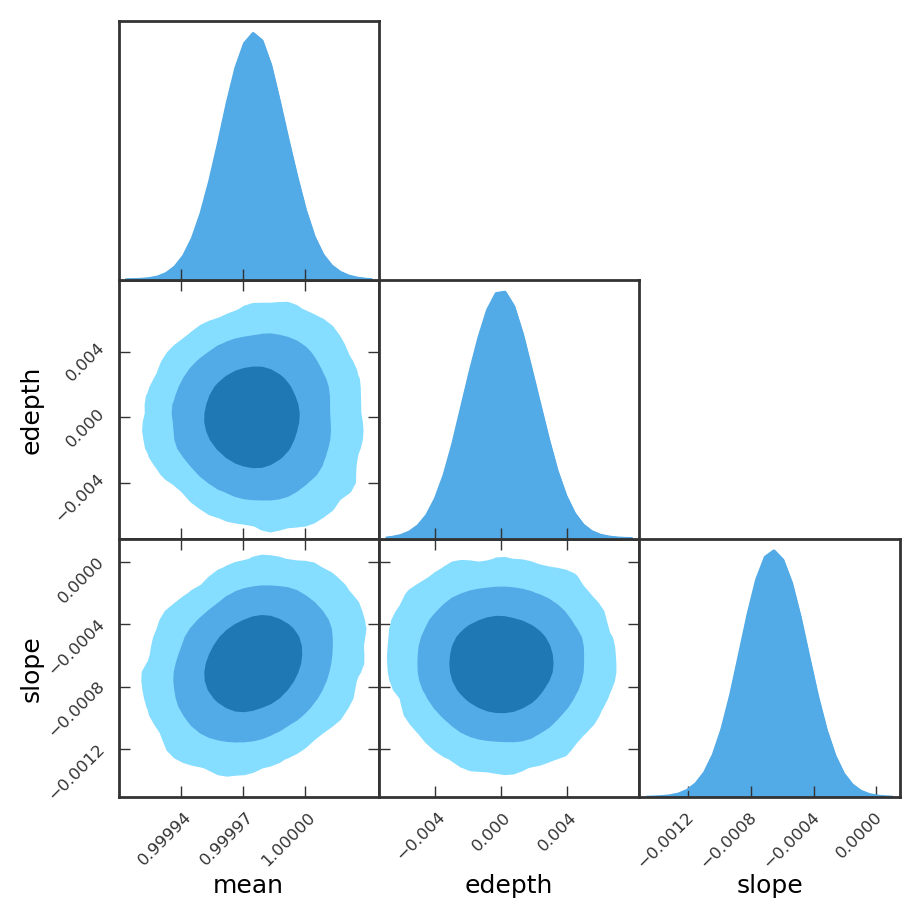

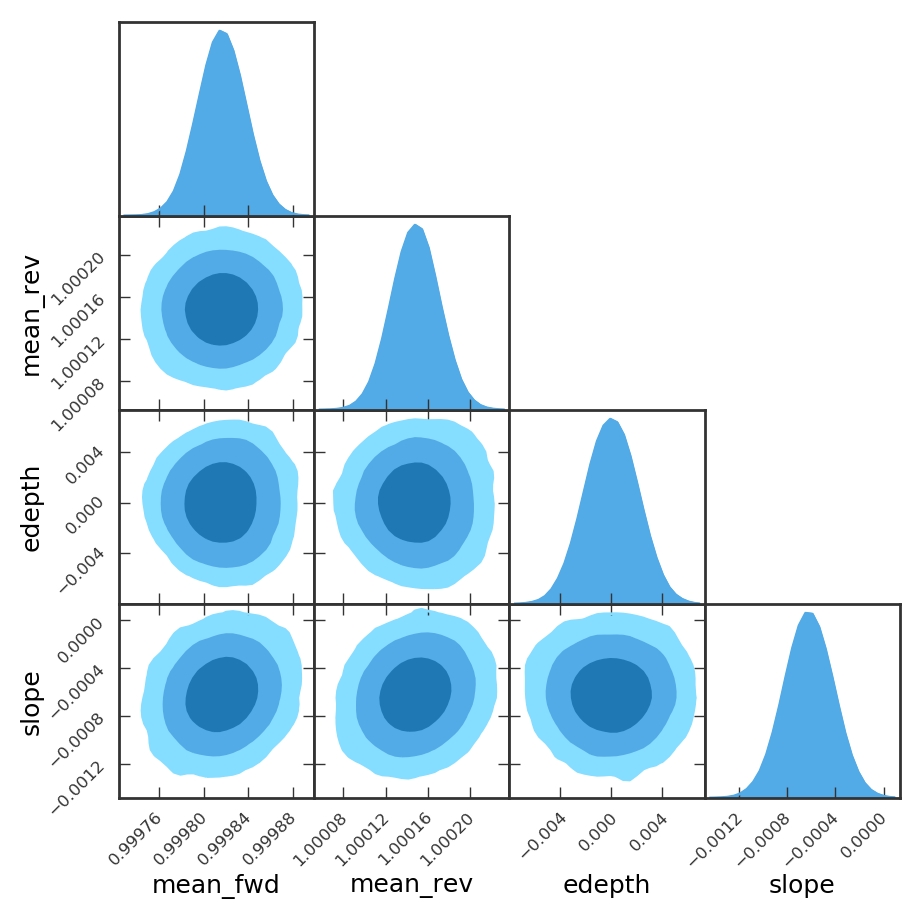

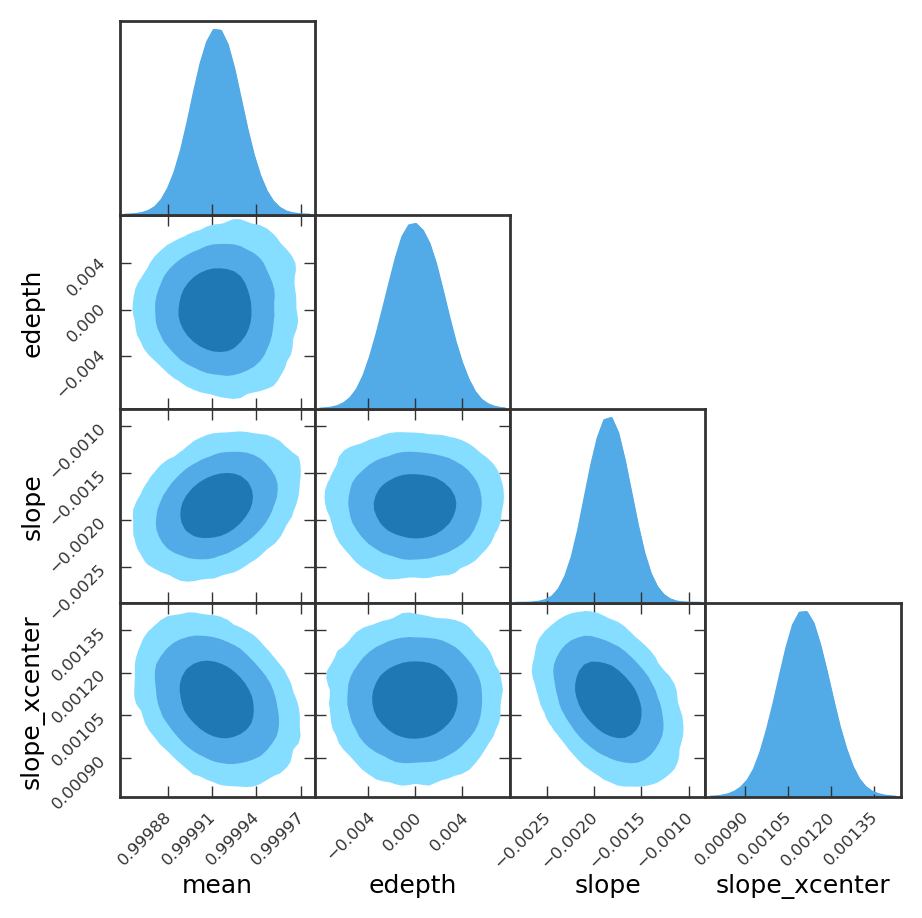

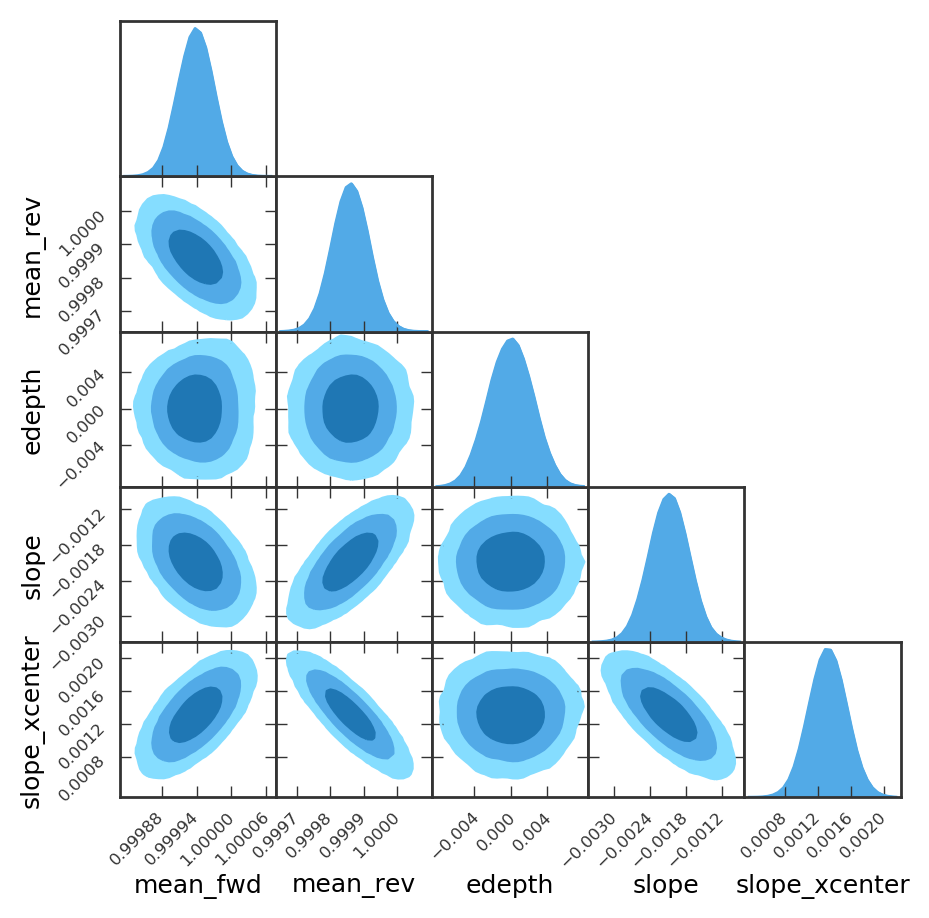

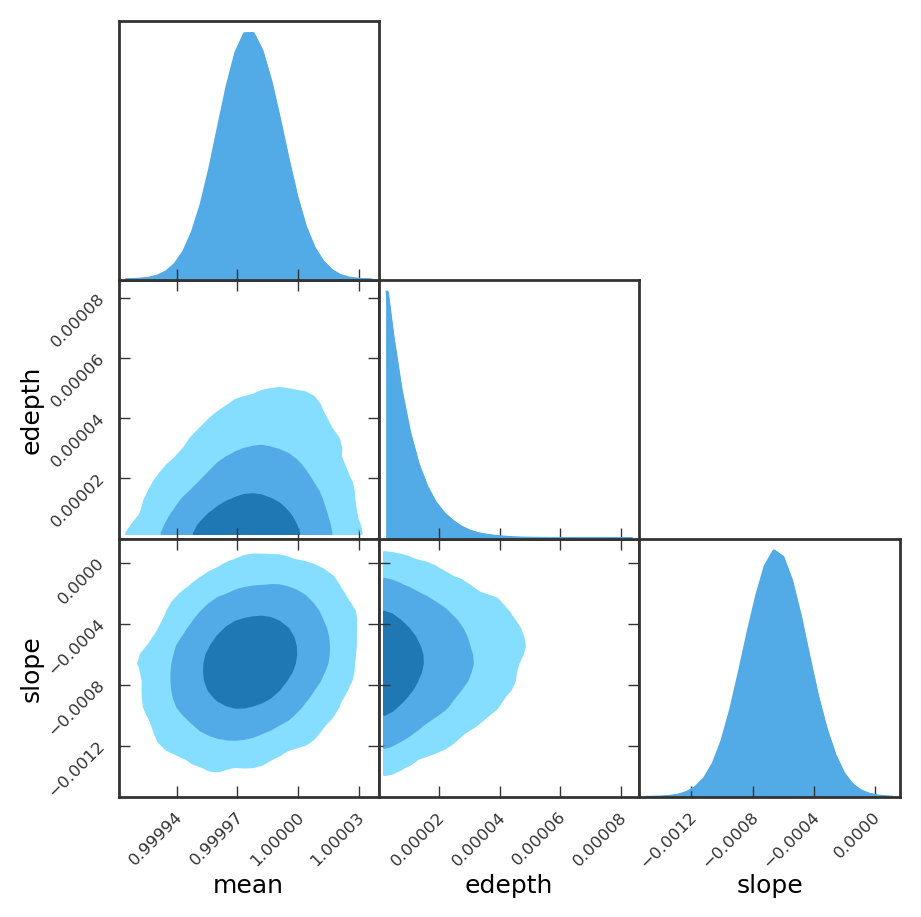

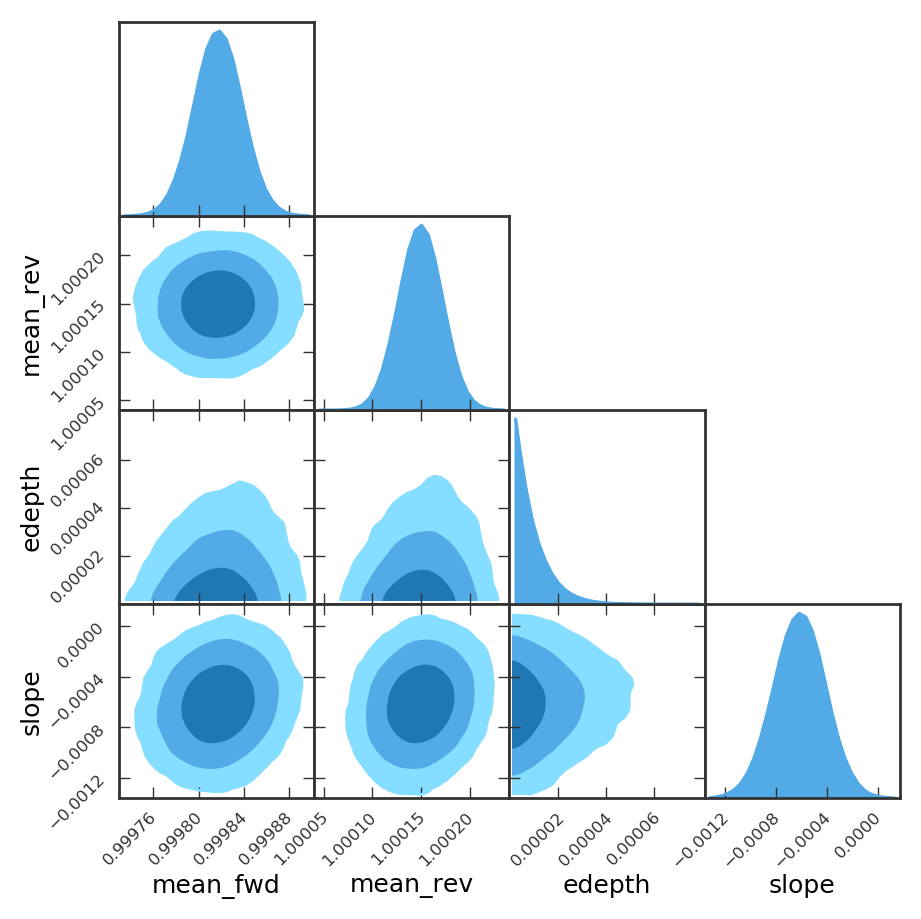

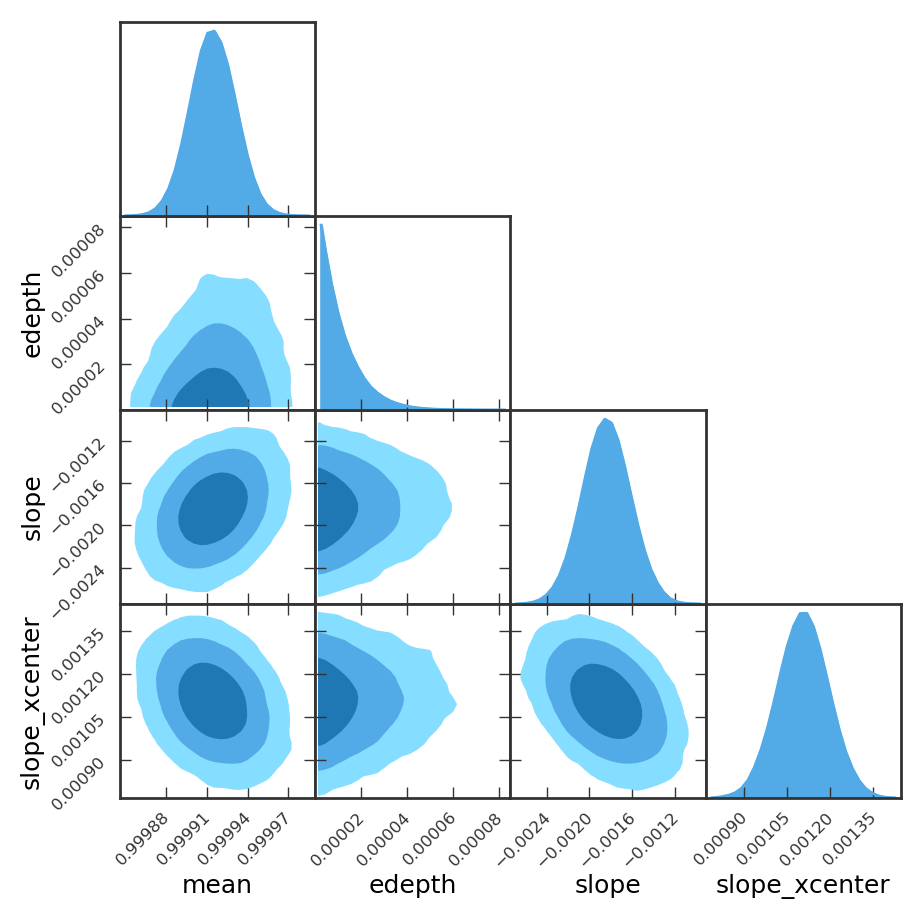

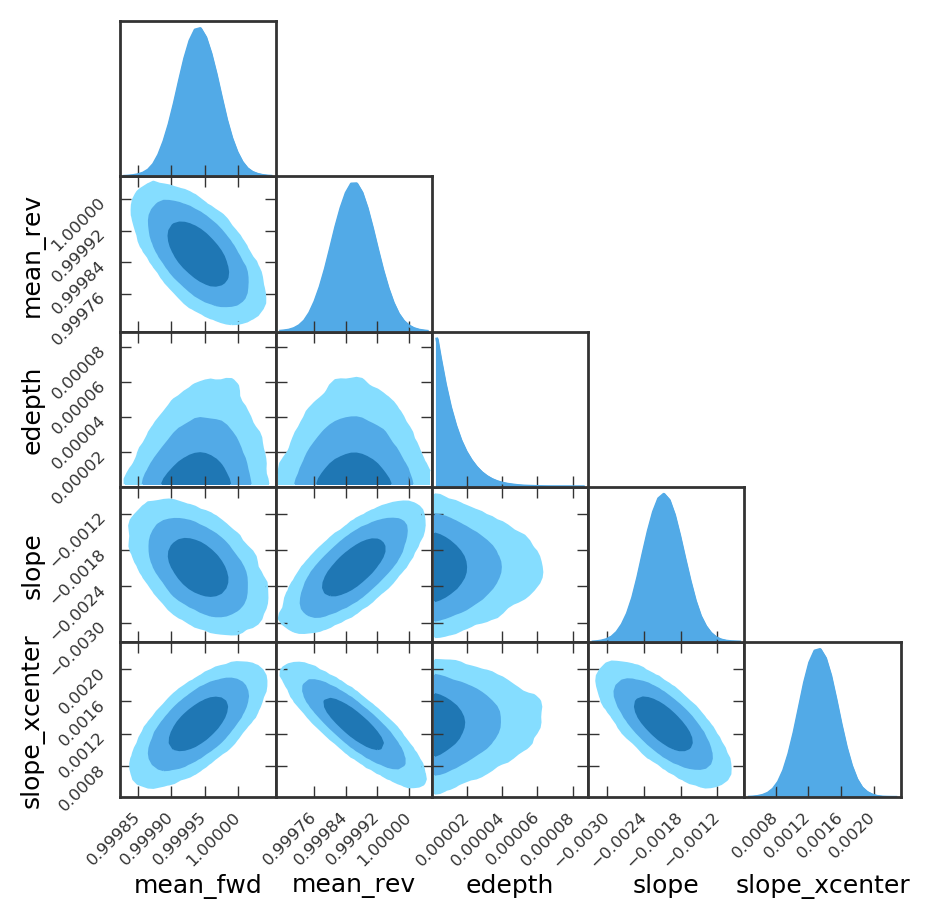

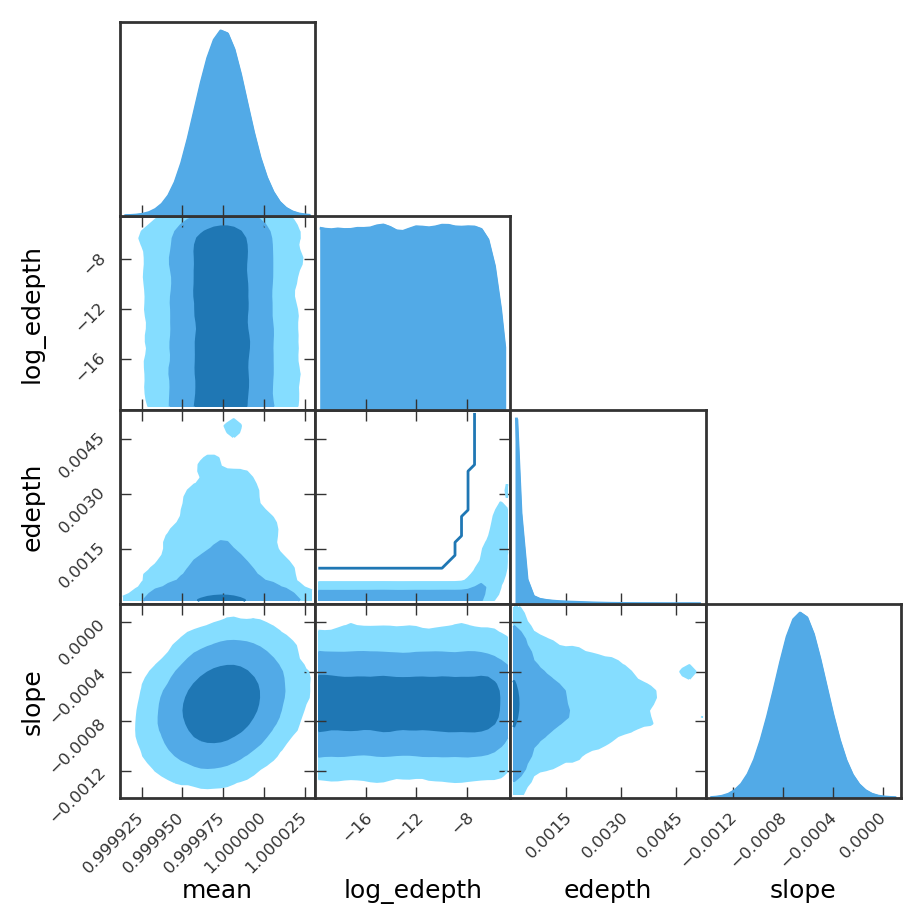

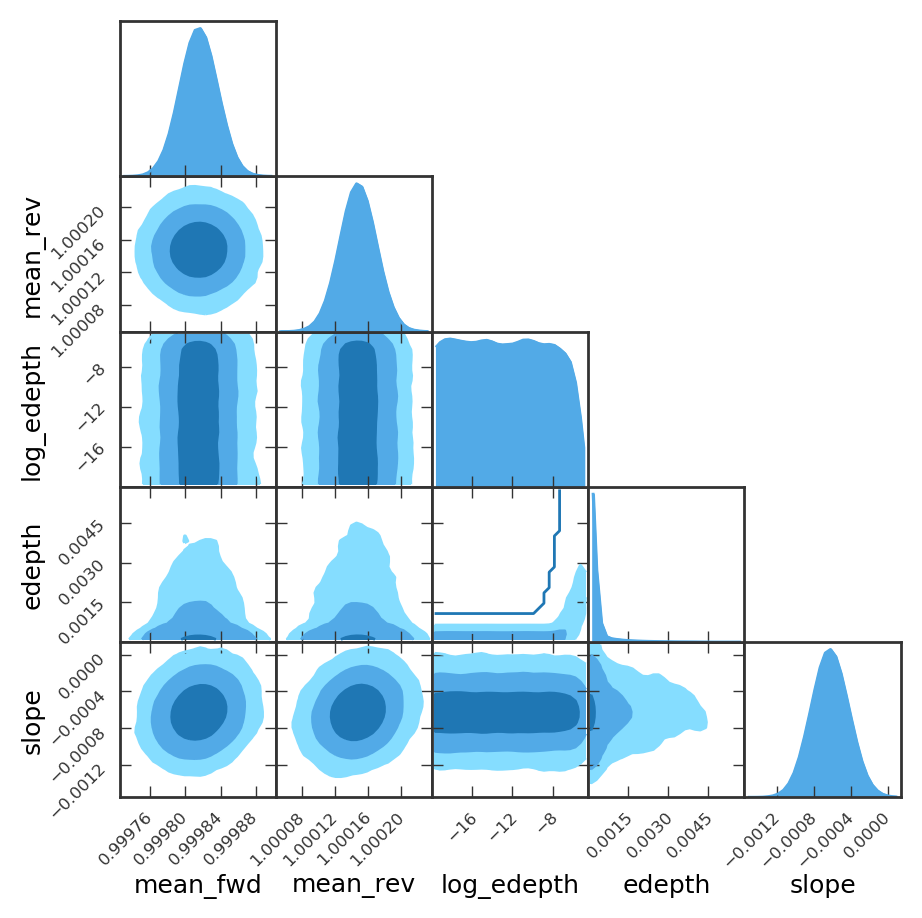

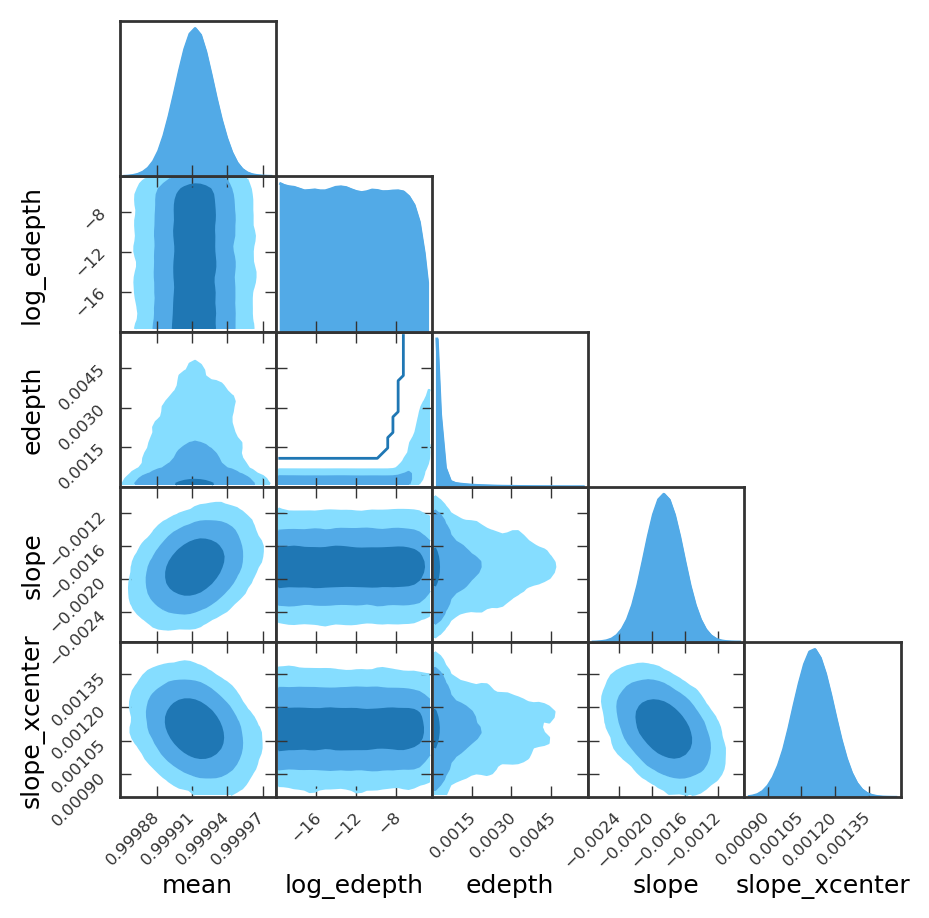

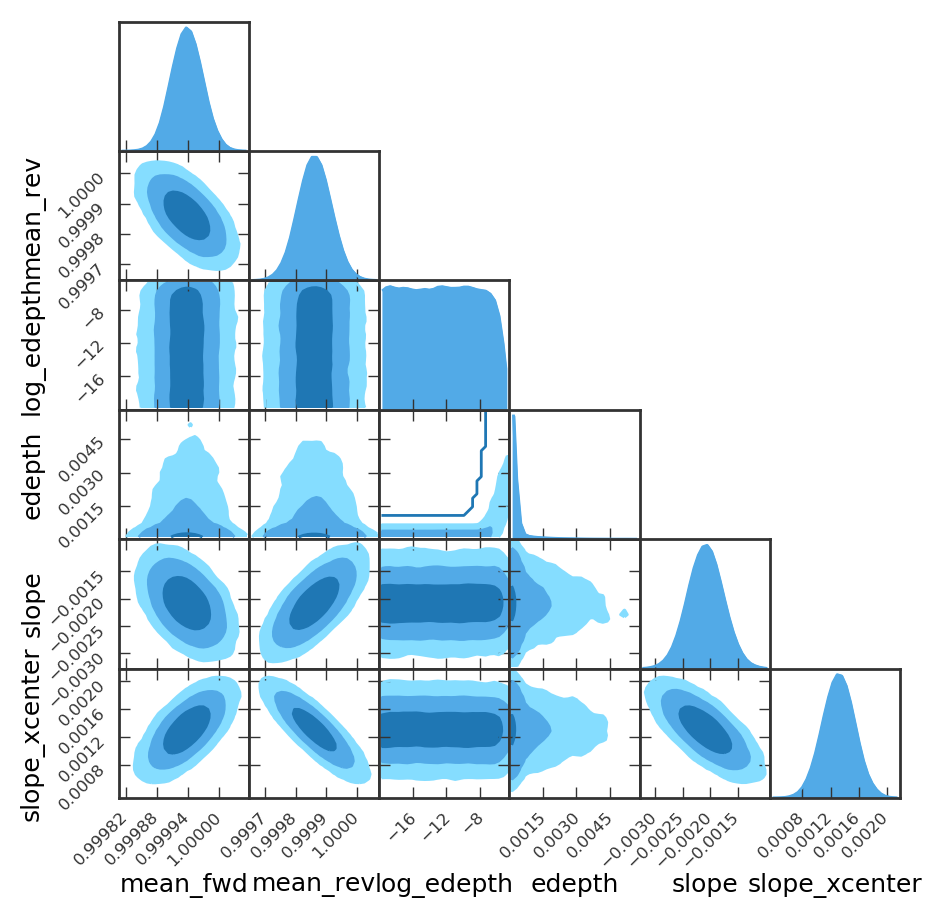

In [234]:
for k, mcmc_fit_ in enumerate(mcmc_fits):
    setup_and_plot_GTC(mcmc_fit_[fine_min_snr_colname])

In [ ]:
[key for key in fine_grain_mcmcs_with_w_xcenter_lin_edepth_w_split['aperture_sum_20x50']['map_soln'].keys()
                if '__' not in key and 'light' not in key]

In [ ]:
pm.summary(trace, varnames=varnames)

In [ ]:
import pygtc
plt.rcParams['figure.figsize'] = 10,10

trace = fine_grain_mcmcs_w_xcenterfit[fine_min_snr_colname]['trace']

samples = pm.trace_to_dataframe(trace, varnames=varnames)
samples['edepth'] = 10**samples['log_edepth']

pygtc.plotGTC(samples, nContourLevels=3);

In [ ]:
from scipy.special import erf
sigmas = erf(np.arange(1,6)/np.sqrt(2))
print(np.percentile(samples['edepth'], sigmas*100)*1e6)
print(10**(np.percentile(samples['log_edepth'], sigmas*100))*1e6)

Now we can plot the simulated data and the maximum a posteriori model to make sure that our initialization looks ok.

## Sampling

Now, let's sample from the posterior defined by this model.
As usual, there are strong covariances between some of the parameters so we'll use :func:`exoplanet.get_dense_nuts_step`.

After sampling, it's important that we assess convergence.
We can do that using the `pymc3.summary` function:

In [ ]:
aper_sum_columns = planet.normed_photometry_df.drop(
    ['xcenter', 'ycenter'], axis=1).columns
aper_sum_columns

In [ ]:
trace_ = fine_grain_mcmcs_w_xcenterfit[fine_min_snr_colname]['trace']
dir(trace_)
trace_.report._gelman_rubin.values()
dir(trace_.report)
trace_.report._run_convergence_checks??

In [ ]:
# fine_grain_mcmcs_w_xcenterfit[fine_min_snr_colname]['map_soln']
edepths = []
means = []
slopes = []
slopes_xcenter = []

edepths_unc = []
means_unc = []
slopes_unc = []
slopes_xcenter_unc = []

mesh_widths = []
mesh_heights = []

for colname in tqdm(aper_sum_columns):
    aper_width_, aper_height_ = np.int32(colname.split('_')[-1].split('x'))
    mesh_widths.append(aper_width_)
    mesh_heights.append(aper_height_)

    # Load Summary from Colname
    summary_df = pm.summary(fine_grain_mcmcs_w_xcenterfit[colname]['trace'], varnames=varnames)

    # Store mean values
    edepths.append(summary_df['mean'].loc['edepth'])
    means.append(summary_df['mean'].loc['mean'])
    slopes.append(summary_df['mean'].loc['slope'])
    slopes_xcenter.append(summary_df['mean'].loc['slope_xcenter'])

    # Store uncertainties
    edepths_unc.append(summary_df['sd'].loc['edepth'])
    means_unc.append(summary_df['sd'].loc['mean'])
    slopes_unc.append(summary_df['sd'].loc['slope'])
    slopes_xcenter_unc.append(summary_df['sd'].loc['slope_xcenter'])

In [ ]:
df_columns = ["aper_width", "aper_height", "edepth", "mean", "slope", "slope_xcenter"]
means_df = pd.DataFrame(np.transpose([mesh_widths, mesh_heights, edepths, means, slopes, slopes_xcenter]), 
                        columns=df_columns)
uncs_df = pd.DataFrame(np.transpose([mesh_widths, mesh_heights, edepths_unc, means_unc, slopes_unc, slopes_xcenter_unc]), 
                        columns=df_columns)

In [ ]:
# mesh_widths_sorted = np.argsort(mesh_widths)
# mesh_heights_sorted = np.argsort(mesh_heights)
plt.plot(means_df['aper_width'], (means_df['edepth'] / uncs_df['edepth']), '.')
plt.plot(means_df['aper_height'], (means_df['edepth'] / uncs_df['edepth']),'.')

plt.figure()
plt.plot(means_df['aper_height']*means_df['aper_width'], (means_df['edepth'] / uncs_df['edepth']),'.')

In [ ]:
mesh_widths_sorted = np.argsort(mesh_widths)
mesh_heights_sorted = np.argsort(mesh_heights)

plt.figure()
plt.plot(means_df['aper_width'], means_df['mean'],'.')
plt.plot(means_df['aper_height'], means_df['mean'],'.')

plt.figure()
plt.plot(means_df['aper_height']*means_df['aper_width'], means_df['mean'],'.')

That looks pretty good!
Fitting this without *exoplanet* would have taken a lot more patience.

Now we can also look at the [corner plot](https://corner.readthedocs.io) of some of that parameters of interest:

In [ ]:
import pygtc
import corner

In [ ]:
trace = fine_grain_mcmcs_w_xcenterfit[fine_min_snr_colname]['trace']

In [ ]:
n_lightcurves_fwd = trace['light_curves_fwd'].shape[0]
light_curves_fwd = trace['light_curves_fwd'].reshape(trace['light_curves_fwd'].shape[:2])#trace['mean_fwd'][:,None]

n_lightcurves_rev = trace['light_curves_rev'].shape[0]
light_curves_rev = trace['light_curves_rev'].reshape(trace['light_curves_rev'].shape[:2])#trace['mean_rev'][:,None]

for k in np.random.choice(np.arange(n_lightcurves_fwd), size=100):
    plt.plot(t[idx_fwd], light_curves_fwd[k], '.', color='C0', alpha=0.25)

for k in np.random.choice(np.arange(n_lightcurves_rev), size=100):
    plt.plot(t[idx_rev], light_curves_rev[k], '.', color='C1', alpha=0.25)

plt.ylim(-1e-5, 1e-6);
plt.xlim(t0_guess - 0.1, t0_guess + 0.1);

In [ ]:
for colname in tqdm(aper_sum_columns):
    trace = fine_grain_mcmcs_w_xcenterfit[colname]['trace']
    
    samples = pm.trace_to_dataframe(trace, varnames=varnames)
    truth = [0.0, 1.0, 1.0, 0.0]
    corner.corner(samples, truths=truth, labels=varnames);

## Phase plots

Like in the radial velocity tutorial (:ref:`rv`), we can make plots of the model predictions for each planet.

In [ ]:
line_fit.shape

In [ ]:
plt.figure()
# Get the posterior median orbital parameters
p = period
# t0 = np.median(trace["t0"])

# Plot the folded data
line_fit =  + trace['slope_xcenter'] + trace['slope']
line_fit = slope * (t-t0_guess) + mean + slope * (xcenters-np.median(xcenters))

plt.errorbar(times[idx_fwd] - t0, (data - line_fit + 1.0)[idx_fwd], yerr=yerr[idx_fwd], fmt=".", color='C0', label="fwd data", zorder=-1000)
plt.errorbar(times[idx_rev] - t0, (data - line_fit + 1.0)[idx_rev], yerr=yerr[idx_rev], fmt=".", color='C3', label="rev data", zorder=-1000)

# Plot the folded model
preds_fwd = trace["light_curves"][:,:,0]
# preds_rev = trace["light_curves"][:,:,0] + trace["mean"][:, None]
pred_fwd = np.median(preds_fwd, axis=0)
# pred_rev = np.median(preds_rev, axis=0)


plt.plot(times - t0, pred_fwd, color="C1", label="model", zorder=10)
# plt.plot(t[idx_rev] - t0, pred_rev, color="C2", label="model", zorder=10)
plt.axhline(1.0, ls='--', color='k')

# Annotate the plot with the planet's period
txt = f"Eclipse Depth = {np.mean(trace['edepth']*1e6):.0f}"
txt += f" +/- {np.std(trace['edepth']*1e6):.0f} ppm"

plt.annotate(
    txt,
    (0, 0),
    xycoords="axes fraction",
    xytext=(5, 5),
    textcoords="offset points",
    ha="left",
    va="bottom",
    fontsize=12,
)

add_traces = False
if add_traces:
    n_traces = 1000
    
    idx_rand = np.random.choice(np.arange(preds_fwd.shape[0]), size=n_traces, replace=False)
    for pred_ in preds_fwd[idx_rand]:
        plt.plot(times - t0, pred_, color="grey", alpha=0.5, zorder=0)

    # idx_rand = np.random.choice(np.arange(preds_fwd.shape[0]), size=n_traces, replace=False)
    # for pred_ in preds_rev[idx_rand]:
    #     plt.plot(t[idx_rev] - t0, pred_, color="grey", alpha=0.5, zorder=0)

plt.legend(fontsize=10, loc=4)
plt.xlim((times - t0).min(), (times - t0).max())
plt.xlabel("Time Since Eclipse [days]")
plt.ylabel("Relative Flux")
plt.title("WASP43 UVIS Eclipse");

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.
This is especially important here because we have used quite a few model components that should be cited.

In [ ]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

In [ ]:
print("\n".join(bib.splitlines()[:10]) + "\n...")